# Forecasting EVI and Population for Himachal


1. Download shape file of Himachal State
2. Make 1x1 Km non-overlapping grids

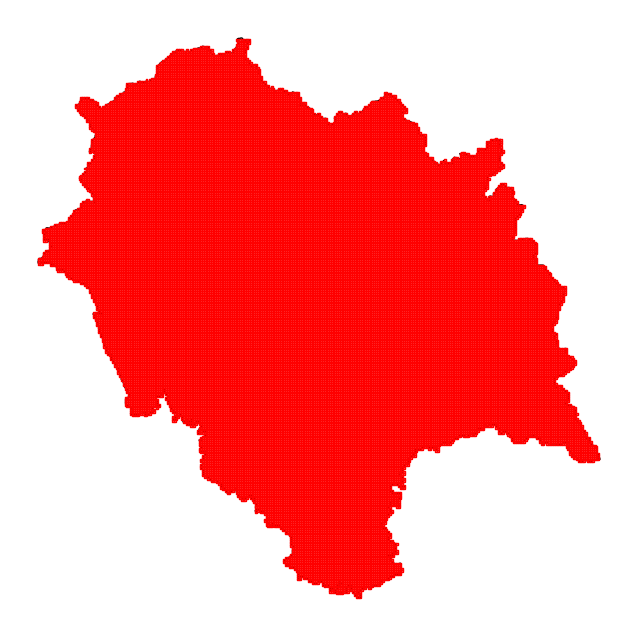

In [15]:
## Create 1x1 km grids

import geopandas as gpd
from shapely.geometry import box
import numpy as np

def create_grid(gdf, cell_size=1000):
    # Get the total bounds of the input geodataframe
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Create a grid of points
    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)
    
    # Create grid cells
    cells = []
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            cells.append(box(x[i], y[j], x[i+1], y[j+1]))
    
    # Create a GeoDataFrame from the grid cells
    grid = gpd.GeoDataFrame({'geometry': cells}, crs=gdf.crs)
    
    # Clip the grid to the shape of the input geodataframe
    grid = grid[grid.intersects(gdf.unary_union)]
    
    return grid

# Load your shapefile
shapefile_path = '/home/sie/Documents/Research_1/Code/himachal_shape/himachal_state.shp'
gdf = gpd.read_file(shapefile_path)

# Create the grid
grid = create_grid(gdf)

# Save the grid to a new shapefile
grid.to_file('/home/sie/Documents/Research_1/Code/himachal_shape/grided_himachal.shp')

# Optionally, plot the result
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='none', edgecolor='black')
grid.plot(ax=ax, color='none', edgecolor='red')
# plt.title('1x1km Grid Over Himachal')
plt.axis('off')
plt.show()

## Download WorldPop data for these grids over a period of 2002 to 2020 using Google Earth Engine

```java
// Function to calculate mean population for a given feature and year
function calculateMeanPopulation(feature, year) {
  var datasetPopulation = ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq('year', year));
  
  var meanPopulation;
  if (datasetPopulation.size().getInfo() === 0) {
    meanPopulation = ee.Number(0);
  } else {
    var population = datasetPopulation.mean();
    meanPopulation = population.reduceRegion({
      reducer: ee.Reducer.mean(),
      geometry: feature.geometry(),
      scale: 100  // 100m resolution
    }).get('population');
  }
  
  return feature.set('mean_population', meanPopulation);
}

// Function to update features in the FeatureCollection with mean population for a given year
function updateFeaturesWithPopulation(fc, year) {
  return fc.map(function(feature) {
    return calculateMeanPopulation(feature, year);
  });
}

// Function to process a chunk of features for population data
function processChunk(chunk, year, chunkIndex) {
  var updatedChunk = updateFeaturesWithPopulation(chunk, year);
  var outputFilename = 'mean_population_' + year + '_chunk_' + chunkIndex;
  
  Export.table.toDrive({
    collection: updatedChunk,
    description: outputFilename,
    fileFormat: 'GeoJSON',
    folder: 'pop_shimla'
  });
  
  print('Exporting chunk ' + chunkIndex + ' for ' + year + ' as ' + outputFilename);
}

// Function to process population data for a given year and save the results
function processYearPopulation(year, gridsEE) {
  var chunkSize = 50000;  // Adjust this based on your needs
  var totalFeatures = gridsEE.size().getInfo();
  
  for (var i = 0; i < totalFeatures; i += chunkSize) {
    var chunk = gridsEE.toList(chunkSize, i);
    chunk = ee.FeatureCollection(chunk);
    processChunk(chunk, year, Math.floor(i / chunkSize));
  }
}

// Load the gridded Shapefile
// Note: In Earth Engine, you would typically load this as an asset
// For this example, let's assume it's already loaded as 'gridsEE'
var gridsEE = ee.FeatureCollection('projects/ee-s23003/assets/grid_shimla');

// Process population data for the years
var years = ee.List.sequence(2002, 2020);

years.evaluate(function(yearList) {
  yearList.forEach(function(year) {
    processYearPopulation(year, gridsEE);
  });
});
```

## Make time series dataframe for Population

In [33]:
import os
import geopandas as gpd
import pandas as pd
from datetime import datetime

# Directory containing the JSON files
directory = "/home/sie/Documents/Research_1/Code/pop_himachal"

# List to store all data
all_data = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".geojson") and filename.startswith("mean_population_"):
        # Extract date from filename
        year = filename.split("_")[2]
        month = 6
        date = datetime(int(year), int(month), 1)  # Assume day 1 for all months

        # Read GeoJSON file using geopandas
        gdf = gpd.read_file(os.path.join(directory, filename))

        # Extract grid data
        for _, row in gdf.iterrows():
            grid_id = row['FID']
            mean_pop = row['mean_population']
            all_data.append({
                'date': date,
                'grid_id': grid_id,
                'mean_pop': mean_pop
            })

# Create DataFrame
df = pd.DataFrame(all_data)

# Sort DataFrame by date and grid_id
df = df.sort_values(['grid_id', 'date'])

# Pivot the DataFrame to create time series for each grid
time_series_df = df.pivot(index='date', columns='grid_id', values='mean_pop')
time_series_df = time_series_df.fillna(0)

# Save the time series data to a CSV file
time_series_df.to_csv('pop_himachal.csv')

print("Time series data has been created and saved.")


Time series data has been created and saved.


In [3]:
import pandas as pd

pop_df = pd.read_csv('/home/sie/Documents/Research_1/Code/pop_himachal.csv')
pop_df

date         0         1         2         3         4         5  \
0   2002-06-01  2.669357  3.191652  3.108958  3.371853  2.650509  3.202850   
1   2003-06-01  2.773027  3.160252  3.106960  3.319719  2.626962  3.066250   
2   2004-06-01  2.651731  2.910770  2.966688  3.038226  2.707094  2.819563   
3   2005-06-01  3.101384  3.136859  3.159899  3.668725  3.594959  3.526766   
4   2006-06-01  3.007139  2.948717  2.899100  3.505775  3.429035  3.327551   
5   2007-06-01  2.874782  2.751160  2.694384  3.042921  3.246091  3.152201   
6   2008-06-01  2.915906  2.906515  2.955995  3.482146  3.331141  3.358166   
7   2009-06-01  3.163043  2.964773  2.899508  3.656926  3.897133  3.426141   
8   2010-06-01  3.317979  3.056084  2.864808  3.727099  3.854701  3.624379   
9   2011-06-01  3.368371  3.019738  2.710291  3.464425  3.961832  3.680045   
10  2012-06-01  3.480619  3.101831  2.916179  3.689464  4.369070  4.047057   
11  2013-06-01  3.380382  3.106669  2.798230  3.647590  5.262272  4.126444   
12  2014-06-01  3.341019  3.103080  2.945401  3.806487  5.222802  4.088880   
13  2015-06-01  3.118739  3.093391  3.096894  3.843748  6.308561  4.148771   
14  2016-06-01  3.064653  3.102041  3.132554  3.803043  6.646651  4.011947   
15  2017-06-01  3.114216  3.439969  3.412243  3.691587  7.198789  4.017671   
16  2018-06-01  3.148291  3.227919  3.372000  3.869563  6.902326  4.057293   
17  2019-06-01  3.201651  3.399655  3.582978  4.002298  6.749229  4.184266   
18  2020-06-01  3.130610  3.552069  3.563461  3.614307  8.238384  3.956430   

           6         7         8  ...     55757     55758     55759     55760  \
0   3.448034  4.229406  2.736760  ...  0.090045  0.068789  0.034513  0.012944   
1   3.255380  4.198292  2.765633  ...  0.093231  0.069838  0.034858  0.013789   
2   3.093336  3.527605  2.746119  ...  0.117865  0.090081  0.036542  0.013171   
3   3.341246  5.156879  3.478999  ...  0.090832  0.068889  0.033470  0.012807   
4   3.144896  4.545301  3.441496  ...  0.090658  0.068555  0.031242  0.012878   
5   3.026492  3.918315  3.257742  ...  0.086489  0.067191  0.029319  0.011548   
6   3.403648  4.557521  3.365979  ...  0.213637  0.155943  0.056604  0.019488   
7   3.346200  4.746807  3.696225  ...  0.246857  0.147030  0.049863  0.018703   
8   3.602231  5.302545  3.696279  ...  0.211183  0.101159  0.045782  0.020333   
9   3.569142  5.201948  3.770149  ...  0.241462  0.118175  0.045955  0.016316   
10  3.761890  5.817803  3.930283  ...  0.157965  0.109304  0.058818  0.030712   
11  3.776673  5.248762  4.098431  ...  0.156567  0.100190  0.054921  0.027286   
12  3.790088  5.554728  3.969920  ...  0.111654  0.079126  0.045438  0.029619   
13  3.956085  5.942336  4.519752  ...  0.152772  0.105249  0.058449  0.024265   
14  3.707327  5.104737  4.367778  ...  0.126156  0.086741  0.043159  0.022348   
15  3.788827  4.744045  4.561827  ...  0.182871  0.122748  0.057717  0.023373   
16  3.827285  5.211994  4.463608  ...  0.141945  0.104149  0.055530  0.025434   
17  3.909232  5.298196  4.567591  ...  0.139149  0.101424  0.056977  0.025603   
18  3.641618  4.440040  4.768193  ...  0.234635  0.158785  0.061639  0.017349   

       55761     55762     55763     55764     55765     55766  
0   0.011241  0.013697  0.120176  0.104427  0.074868  0.042466  
1   0.011803  0.014872  0.118693  0.104320  0.076280  0.045254  
2   0.011098  0.012554  0.135818  0.126514  0.087016  0.041989  
3   0.011188  0.014358  0.113344  0.094017  0.066687  0.038495  
4   0.010989  0.014565  0.097488  0.088273  0.063188  0.035009  
5   0.010161  0.011573  0.095121  0.088520  0.065449  0.032374  
6   0.016274  0.017566  0.332593  0.269489  0.189602  0.112872  
7   0.015144  0.016443  0.375828  0.309970  0.227583  0.131677  
8   0.016418  0.017759  0.358040  0.276454  0.196919  0.105725  
9   0.012989  0.013509  0.414428  0.351497  0.262726  0.095636  
10  0.079489  0.160825  0.401359  0.305623  0.199635  0.073909  
11  0.080215  0.170324  0.403323  0.326819  0.21

## Plot total population

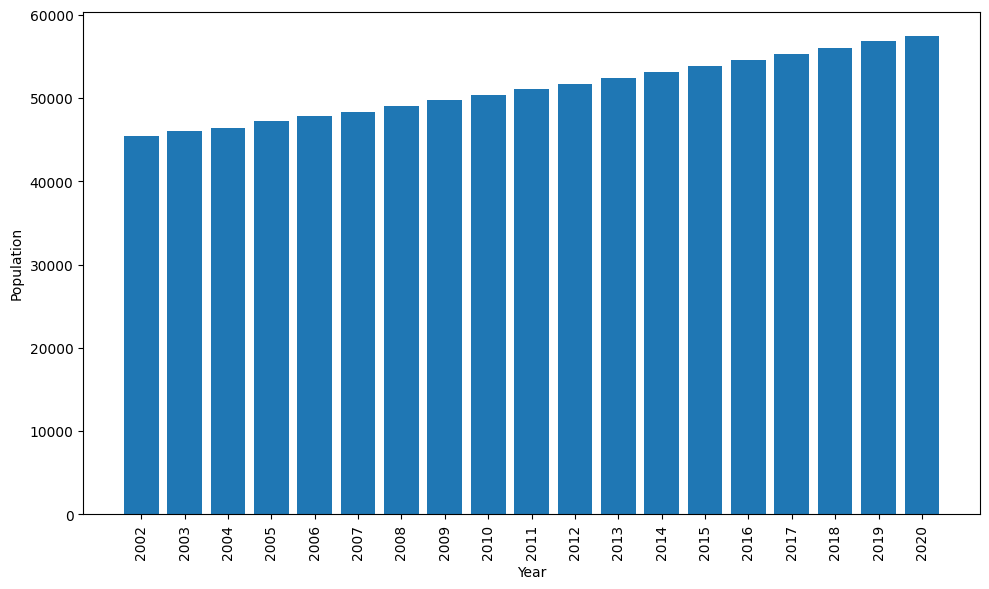

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

time_series_df = pd.read_csv('pop_himachal.csv')
# Assuming 'time_series_df' is your original DataFrame with a 'date' column
df = time_series_df.drop('date', axis=1)

# Calculate row-wise sum
row_sums = df.sum(axis=1)

# Plot row-wise sums
years = [y.split('-')[0] for y in time_series_df['date']]
plt.figure(figsize=(10, 6))
plt.bar(years, row_sums)
plt.xticks(ticks=range(len(time_series_df['date'])), labels=years, rotation=90)
plt.xlabel('Year')
plt.ylabel('Population')
plt.tight_layout()
plt.show()


In [9]:
list(row_sums)

[45468.48836113932,
 46004.1217321437,
 46460.13527302355,
 47214.28234579823,
 47806.6552936874,
 48325.948142897316,
 49025.79389421305,
 49741.323032417255,
 50396.6846146687,
 51085.6981623094,
 51704.4823363363,
 52347.30290823536,
 53137.37701303499,
 53804.082898154935,
 54567.36288684129,
 55255.586555456495,
 56060.21319756619,
 56799.86015397619,
 57477.67463830815]

## Plot total evi

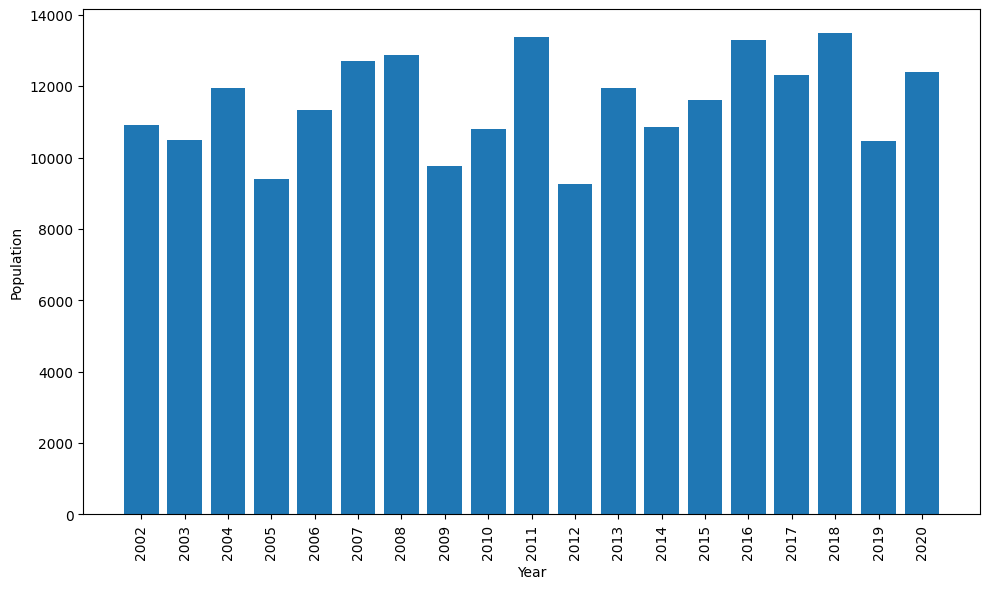

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

time_series_df = pd.read_csv('evi_himachal.csv')
# Assuming 'time_series_df' is your original DataFrame with a 'date' column
df = time_series_df.drop('date', axis=1)

# Calculate row-wise sum
row_sums = df.sum(axis=1)

# Plot row-wise sums
years = [y.split('-')[0] for y in time_series_df['date']]
plt.figure(figsize=(10, 6))
plt.bar(years, row_sums)
plt.xticks(ticks=range(len(time_series_df['date'])), labels=years, rotation=90)
plt.xlabel('Year')
plt.ylabel('Population')
plt.tight_layout()
plt.show()


In [13]:
row_sums

0     10907.910539
1     10483.866868
2     11964.249184
3      9392.757028
4     11334.704412
5     12702.708063
6     12886.662760
7      9773.831919
8     10813.588839
9     13373.163734
10     9264.859728
11    11953.661403
12    10846.681097
13    11615.145059
14    13303.682267
15    12321.406666
16    13482.978778
17    10478.683662
18    12409.676176
dtype: float64

<Axes: >

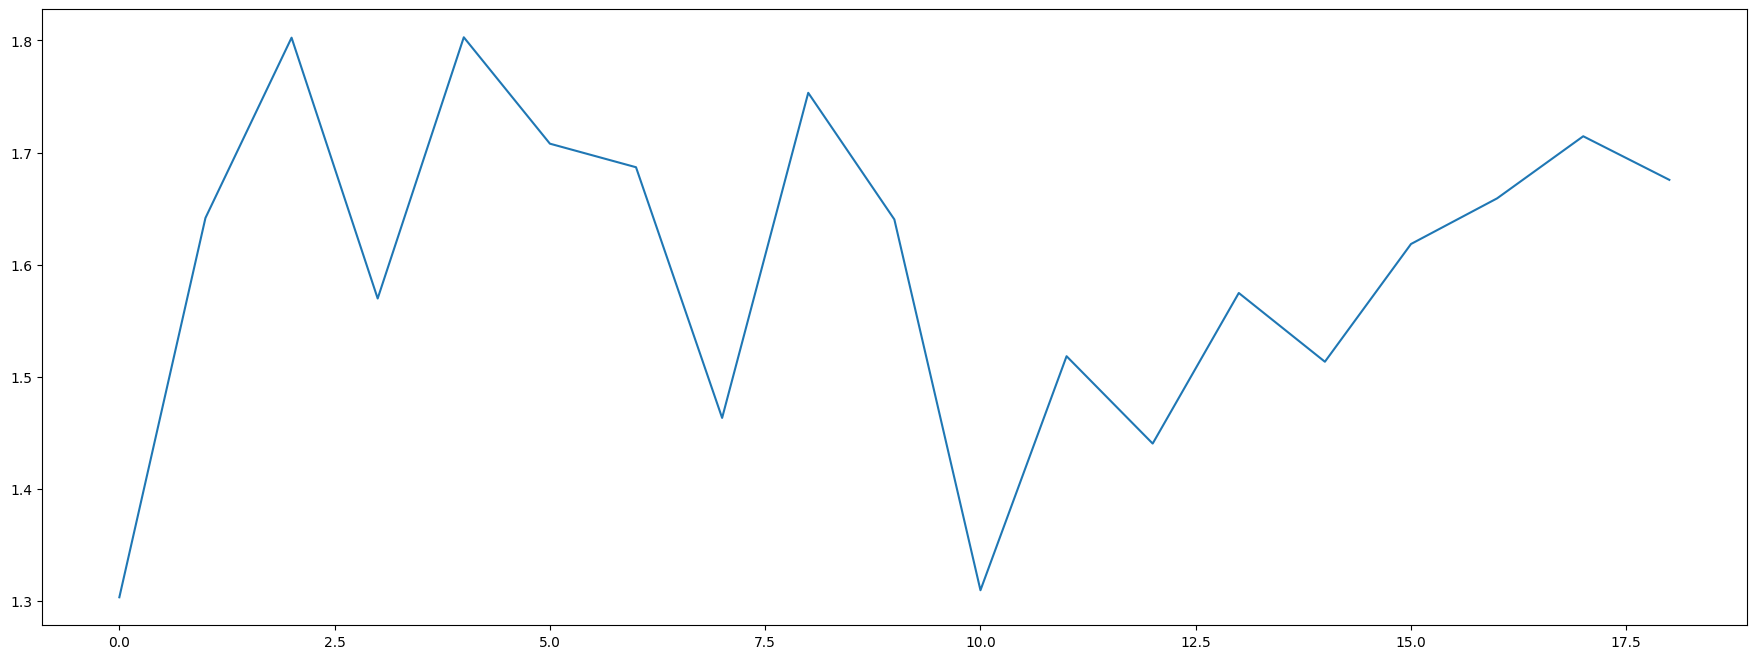

In [49]:
## Plot random grid's population
import numpy as np

grid_id = np.random.randint(1, 55000)
time_series_df.iloc[:, grid_id].plot(figsize=(22, 8))

## Plot raster

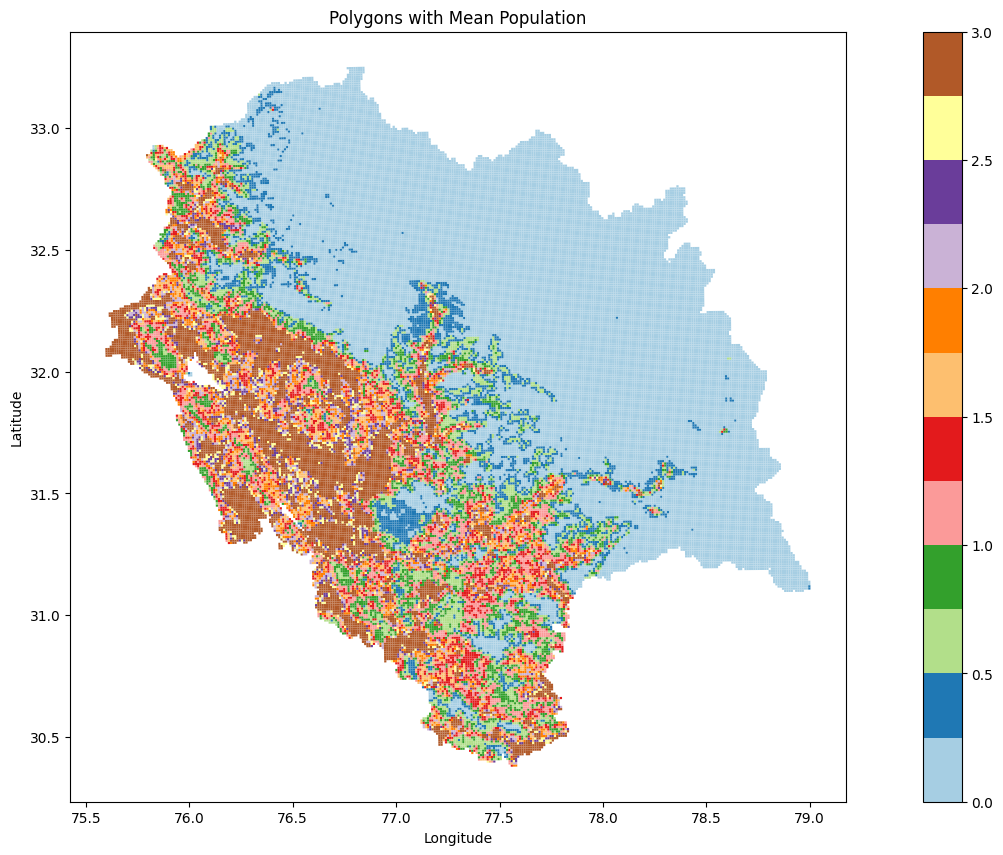

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import json

file_path = '/home/sie/Documents/Research_1/Code/pop_himachal/mean_population_2020_chunk_0.geojson'
# Load the GeoJSON data
gdf = gpd.read_file(file_path)

# Plot the polygons
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
gdf.plot(column='mean_population', cmap='Paired', legend=True, ax=ax, vmin=0, vmax=3)
plt.title("Polygons with Mean Population")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


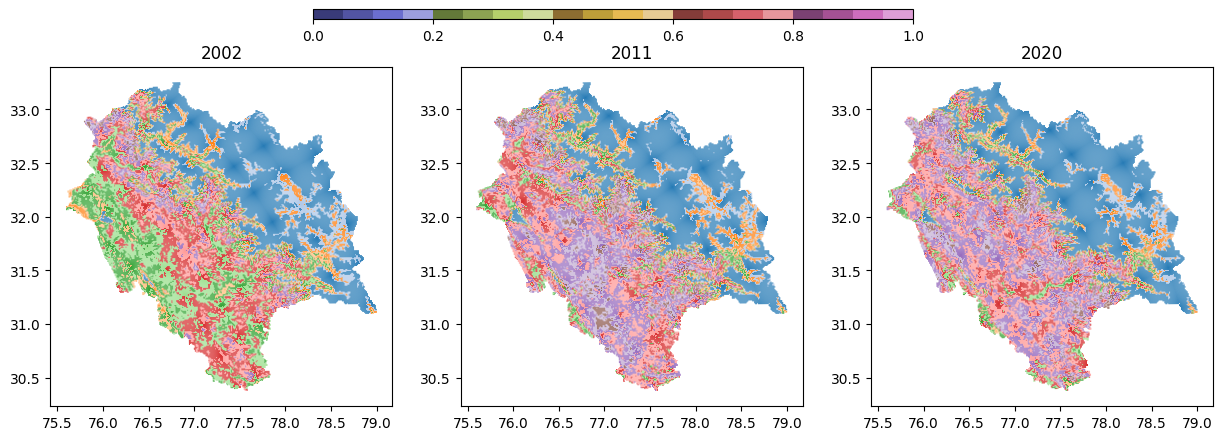

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/'

# Get list of GeoJSON files in the directory
geojson_files = ['Code/pop_himachal/mean_population_2002_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2011_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2020_chunk_0.geojson']

# Number of rows and columns for subplots
n_cols = 3
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 1  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # Plot each GeoDataFrame in the corresponding subplot
    gdf.plot(column='mean_evi', cmap='tab20', ax=axes[i], norm=norm)
    axes[i].set_title(file_name.split('_')[3])


# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common colorbar at the top
cbar_ax = fig.add_axes([0.3, 0.93, 0.4, 0.02])  # Position for the colorbar
sm = plt.cm.ScalarMappable(cmap='tab20b', norm=norm) # Paired
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')


# plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to make space for colorbar
# Save the plot as a PDF
plt.savefig('pop_raster_himachal.pdf', format='pdf')
plt.show()

KeyError: 'mean_evi'

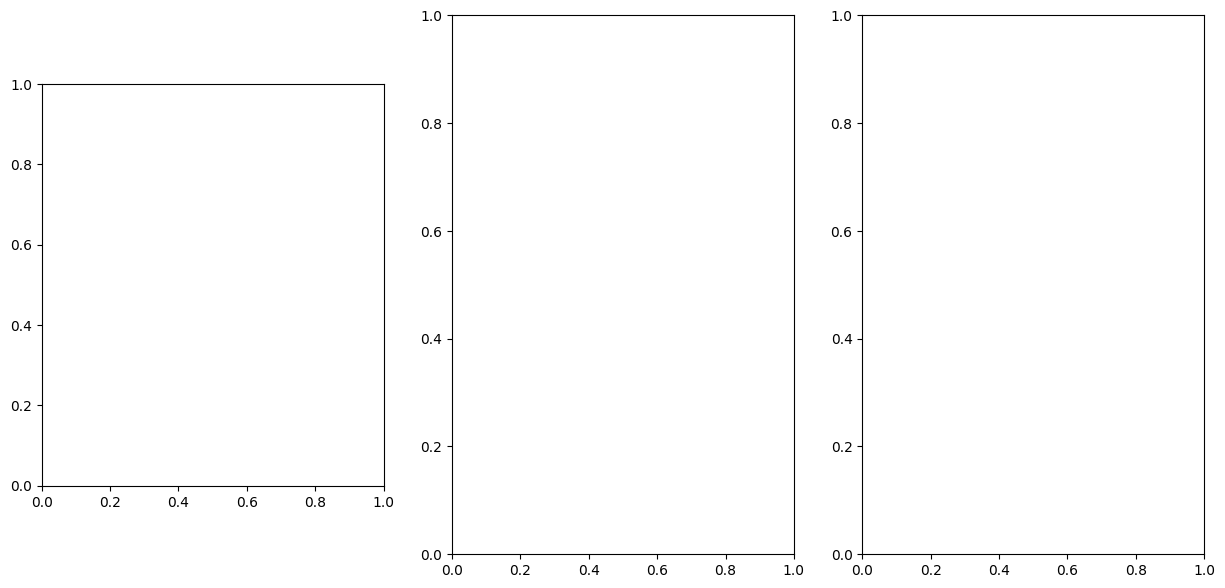

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/'

# Get list of GeoJSON files in the directory
geojson_files = ['Code/pop_himachal/mean_population_2002_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2011_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2020_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'Code/himachal_shape/filtered_grids_hamirpur.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 3
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows+2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 10  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]
    
    # Plot each filtered GeoDataFrame in the corresponding subplot
    filtered_gdf.plot(column='mean_evi', cmap='Paired', ax=axes[i], norm=norm)
    axes[i].set_title(file_name.split('_')[3])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common colorbar at the top
cbar_ax = fig.add_axes([0.3, 0.93, 0.4, 0.02])  # Position for the colorbar
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm) # Paired
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Save the plot as a PDF
plt.savefig('pop_raster_hamirpur.pdf', format='pdf')
plt.show()

### Main


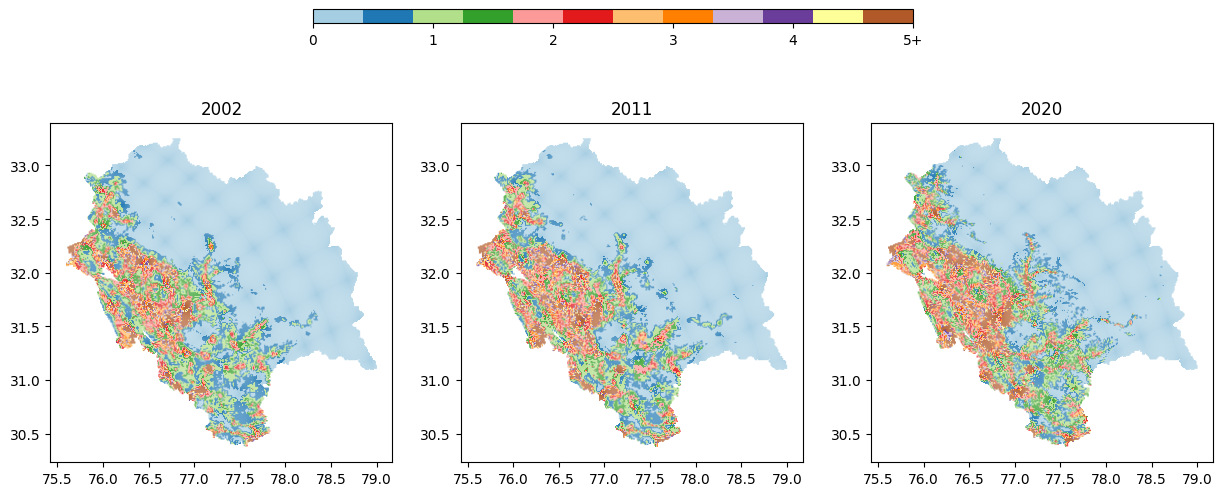

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/'

# Get list of GeoJSON files in the directory
geojson_files = ['Code/pop_himachal/mean_population_2002_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2011_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2020_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'Code/himachal_shape/filtered_grids_mandi.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 3
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows+2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 5  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]
    
    # Plot each filtered GeoDataFrame in the corresponding subplot
    gdf.plot(column='mean_population', cmap='Paired', ax=axes[i], norm=norm)
    axes[i].set_title(file_name.split('_')[3])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common colorbar at the top with added space
cbar_ax = fig.add_axes([0.3, 0.88, 0.4, 0.02])  # Move the colorbar down (increase space)
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels (for example, 25 custom labels)
custom_labels = ['0', '1', '2', '3', '4', '5+']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('pop_raster_himachal.pdf', format='pdf')
plt.show()


In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/'

# Get list of GeoJSON files in the directory
geojson_files = ['Code/pop_himachal/mean_population_2002_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2011_chunk_0.geojson',
                'Code/pop_himachal/mean_population_2020_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'Code/himachal_shape/filtered_grids_hamirpur.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = min(3, len(geojson_files))  # Limit to 3 columns max
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure with adjusted size based on number of rows
fig = plt.figure(figsize=(5 * n_cols, 5 * n_rows + 1))  # +1 for colorbar space

# Create a color normalization object for common color range
vmin, vmax = 0, 5  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    
    # Plot each filtered GeoDataFrame in the corresponding subplot
    filtered_gdf.plot(column='mean_population', cmap='Paired', ax=ax, norm=norm)
    ax.set_title(file_name.split('_')[3])
    ax.axis('off')  # Turn off axis

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the bottom value (0.03) to create space for colorbar

# Add a common colorbar at the bottom with a little space
cbar_ax = fig.add_axes([0.3, 0.02, 0.4, 0.02])  # Adjust the bottom value (0.02) to position the colorbar
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels
custom_labels = ['0', '1', '2', '3', '4', '5+']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('pop_raster_hamirpur.pdf', format='pdf', bbox_inches='tight')
plt.show()

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

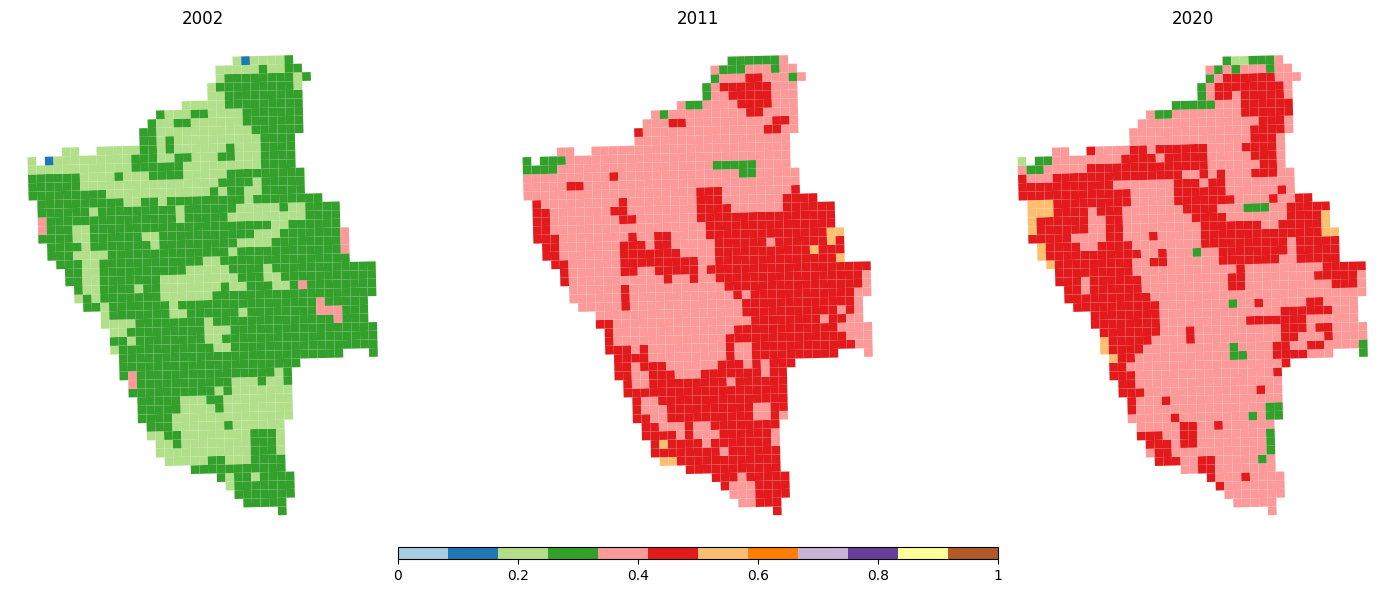

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/'

# Get list of GeoJSON files in the directory
geojson_files = ['Code/evi_himachal/mean_evi_2002_06_chunk_0.geojson',
                'Code/evi_himachal/mean_evi_2011_06_chunk_0.geojson',
                'Code/evi_himachal/mean_evi_2020_06_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'Code/himachal_shape/filtered_grids_hamirpur.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = min(3, len(geojson_files))  # Limit to 3 columns max
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure with adjusted size based on number of rows
fig = plt.figure(figsize=(5 * n_cols, 5 * n_rows + 1))  # +1 for colorbar space

# Create a color normalization object for common color range
vmin, vmax = 0, 1  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    
    # Plot each filtered GeoDataFrame in the corresponding subplot
    filtered_gdf.plot(column='mean_evi', cmap='Paired', ax=ax, norm=norm)
    ax.set_title(file_name.split('_')[3])
    ax.axis('off')  # Turn off axis

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the bottom value (0.03) to create space for colorbar

# Add a common colorbar at the bottom with a little space
cbar_ax = fig.add_axes([0.3, 0.02, 0.4, 0.02])  # Adjust the bottom value (0.02) to position the colorbar
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels
custom_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('evi_raster_hamirpur.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [40]:
import geopandas as gpd
import pandas as pd
import os

# Directory containing the GeoJSON files
directory = '/home/sie/Documents/Research_1/Code/pop_himachal'

# Get list of GeoJSON files in the directory (with years for easier tracking)
geojson_files = {
    '2002': 'mean_population_2002_chunk_0.geojson',
    '2003': 'mean_population_2003_chunk_0.geojson',
    '2004': 'mean_population_2004_chunk_0.geojson',
    '2005': 'mean_population_2005_chunk_0.geojson',
    '2006': 'mean_population_2006_chunk_0.geojson',
    '2007': 'mean_population_2007_chunk_0.geojson',
    '2008': 'mean_population_2008_chunk_0.geojson',
    '2009': 'mean_population_2009_chunk_0.geojson',
    '2010': 'mean_population_2010_chunk_0.geojson',
    '2011': 'mean_population_2011_chunk_0.geojson',
    '2012': 'mean_population_2012_chunk_0.geojson',
    '2013': 'mean_population_2013_chunk_0.geojson',
    '2014': 'mean_population_2014_chunk_0.geojson',
    '2015': 'mean_population_2015_chunk_0.geojson',
    '2016': 'mean_population_2016_chunk_0.geojson',
    '2017': 'mean_population_2017_chunk_0.geojson',
    '2018': 'mean_population_2018_chunk_0.geojson',
    '2019': 'mean_population_2019_chunk_0.geojson',
    '2020': 'mean_population_2020_chunk_0.geojson',
}

# Path to the filtered GeoJSON file
filtered_geojson_path = '/home/sie/Documents/Research_1/Code/himachal_shape/filtered_grids_mandi.geojson'

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes FID is the grid_id column

# Initialize an empty list to store the total EVI values per year
total_evi_data = []

# Loop through GeoJSON files and calculate total EVI for each year
for year, file_name in geojson_files.items():
    file_path = os.path.join(directory, file_name)
    
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)
    
    # # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    # filtered_gdf_year = gdf[gdf['FID'].isin(filtered_grid_ids)]
    
    # Sum the EVI values for the filtered grids
    total_evi = gdf['mean_population'].sum()
    
    # Append the result to the list
    total_evi_data.append({'Year': year, 'Total_Population': total_evi})

# Convert the list to a DataFrame
total_evi_df = pd.DataFrame(total_evi_data)

# Save the total EVI values to a CSV file
csv_output_path = os.path.join('/home/sie/Documents/Research_1/Code/', 'total_population_himachal.csv')
total_evi_df.to_csv(csv_output_path, index=False)

print(f"CSV file saved at: {csv_output_path}")

CSV file saved at: /home/sie/Documents/Research_1/Code/total_population_himachal.csv


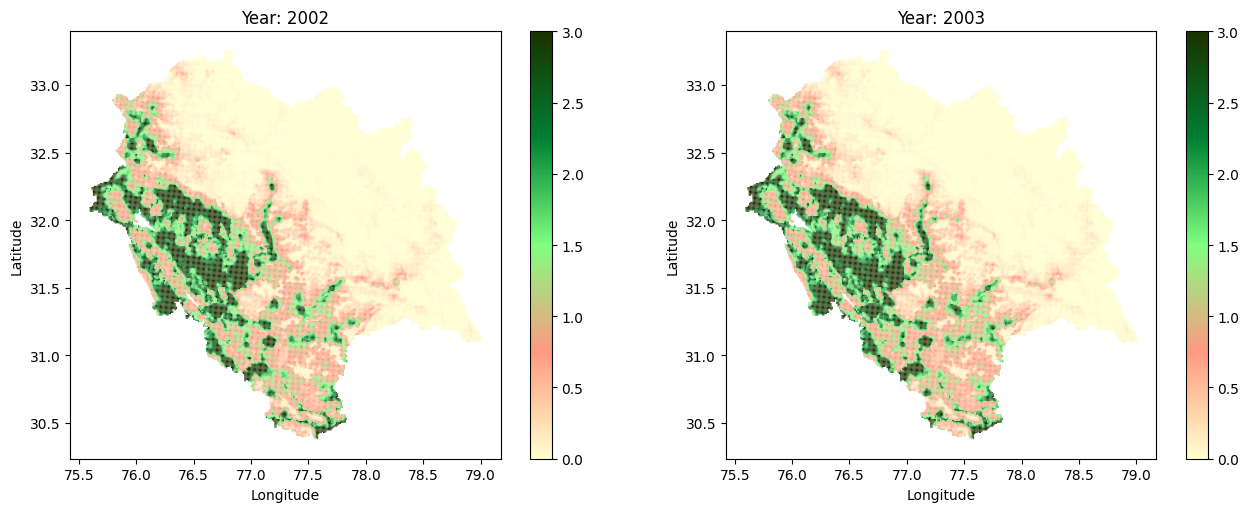

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import math

# Number of subplots
n = 2003 - 2001

# Number of columns
ncols = 3

# Calculate the number of rows
nrows = math.ceil(n / ncols)

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 5 * nrows))

# Flatten axs array for easy indexing if n is less than nrows * ncols
axs = axs.flatten()
i = 0

# Create the colormap
colors = [
    (1, 1, 0.8),  
    (1, 0.6, 0.5),
    (0.5, 1, 0.5),
    (0, 0.5, 0.2), 
    (0.1, 0.2, 0)
]

# Create the colormap
cmap_name = 'yellow_green'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=255)


for year in range(2002, 2004):
    file_name = 'pop_himachal/mean_population_' + str(year) + '_chunk_0.geojson'
    gdf = gpd.read_file(file_name)          # gdf.iloc[index_list]
    gdf.plot(column='mean_population', cmap=cmap, legend=True, ax=axs[i], vmin=0.0, vmax=3)
    
    # Customizing the plot
    axs[i].set_title(f'Year: {year}')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    i += 1

# Hide any unused subplots
for j in range(i, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# Save the plot as an SVG file
# plt.savefig("evi_himachal.pdf", format='pdf')
plt.show()



In [7]:
## Save tif as pdf

# import rasterio
# import matplotlib.pyplot as plt

# # File path to your raster file (e.g., GeoTIFF)
# raster_file = '/home/sie/Documents/Research_1/Code/yearwise_pop/mean_pop_2002-06-01.tif'

# # Open the raster file
# with rasterio.open(raster_file) as src:
#     # Read the first band (assuming single band raster)
#     raster_data = src.read(1)
#     # Get the extent of the image for proper plotting
#     extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

# # Plotting the raster data using matplotlib
# plt.figure(figsize=(10, 10))
# plt.imshow(raster_data, cmap='viridis', extent=extent)
# plt.colorbar(label='Pixel Values')
# plt.title('Raster Image')

# # # Save the plot as a PDF
# # plt.savefig('output_raster.pdf', format='pdf')
# # plt.show()


## Download EVi data for these grids over a period of 2002 to 2020 using Google Earth Engine

```java
// Function to calculate mean EVI for a given feature, year, and month
function calculateMeanEVI(feature, year, month) {
  var startDate = ee.Date.fromYMD(year, month, 1);
  var endDate = startDate.advance(1, 'month');

  // Filter EVI data
  var datasetEVI = ee.ImageCollection('MODIS/061/MOD13A1')
                      .filterDate(startDate, endDate)
                      .select('EVI')
                      .mean()
                      .multiply(0.0001);  // Scale factor
  
  // Calculate mean EVI
  var meanEVI = datasetEVI.reduceRegion({
    reducer: ee.Reducer.mean(),
    geometry: feature.geometry(),
    scale: 1000,  // Adjusted scale to reduce pixels
    maxPixels: 1e9  // Increased maxPixels limit
  }).get('EVI');

  // Set the mean EVI property to the feature
  return feature.set('mean_evi', meanEVI);
}

// Function to update features with mean EVI for a given year and month
function updateFeaturesWithEVI(fc, year, month) {
  return fc.map(function(feature) {
    return calculateMeanEVI(feature, year, month);
  });
}

// Function to save the FeatureCollection to a JSON file in Google Drive
function saveToDrive(fc, year, month, chunkIndex) {
  var fileName = 'mean_evi_' + year + '_' + ('0' + month).slice(-2) + '_chunk_' + chunkIndex;
  Export.table.toDrive({
    collection: fc,
    description: fileName,
    fileFormat: 'GeoJSON',
    folder: 'evi_himachal'  // Specify the folder in your Google Drive
  });
}

// Function to process chunks of features
function processChunk(fc, year, month, chunkIndex) {
  var updatedChunk = updateFeaturesWithEVI(fc, year, month);
  saveToDrive(updatedChunk, year, month, chunkIndex);
}

// Function to process all months for a given year
function processYear(year, grids) {
  var chunkSize = 15000;  // Adjust this based on your needs
  var totalFeatures = grids.size().getInfo();

  for (var month = 1; month <= 12; month++) {
    for (var i = 0; i < totalFeatures; i += chunkSize) {
      var chunk = grids.toList(chunkSize, i);
      var chunkFC = ee.FeatureCollection(chunk);
      processChunk(chunkFC, year, month, Math.floor(i / chunkSize));
    }
  }
}


// Initialize the Earth Engine library
var grids = ee.FeatureCollection('projects/ee-s23003/assets/grid_himachal_2');  // Replace with your asset path

var years = ee.List.sequence(2016, 2020);  // 2002 to 2004 inclusive

years.evaluate(function(yearList) {
  yearList.forEach(function(year) {
    processYear(year, grids);
  });
});
```

## Make time series dataframe for EVI

In [1]:
import os
import geopandas as gpd
import pandas as pd
from datetime import datetime

# Directory containing the GeoJSON files
directory = "evi_monthly/"

# List to store all data
all_data = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".geojson") and filename.startswith("mean_evi_"):
        # Extract date from filename
        year = filename.split("_")[2]
        month = filename.split("_")[3]
        date = datetime(int(year), int(month), 1)  # Assume day 1 for all months

        # Read GeoJSON file using geopandas
        gdf = gpd.read_file(os.path.join(directory, filename))

        # Extract grid data
        for _, row in gdf.iterrows():
            grid_id = row['FID']
            mean_evi = row['mean_evi']
            all_data.append({
                'date': date,
                'grid_id': grid_id,
                'mean_evi': mean_evi
            })

# Create DataFrame
df = pd.DataFrame(all_data)

# Sort DataFrame by date and grid_id
df = df.sort_values(['grid_id', 'date'])

# Pivot the DataFrame to create time series for each grid
time_series_df = df.pivot(index='date', columns='grid_id', values='mean_evi')

# Save the time series data to a CSV file
time_series_df.to_csv('evi_himachal_monthly.csv')

print("Time series data has been created.")


Time series data has been created.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

evi_df = pd.read_csv('evi_himachal_monthly.csv')
evi_df

date         0         1         2         3         4         5  \
0    2002-01-01  0.276265  0.272355  0.233768  0.238128  0.303965  0.291964   
1    2002-02-01  0.357021  0.360232  0.305397  0.314554  0.389839  0.376916   
2    2002-03-01  0.322729  0.310812  0.270228  0.267441  0.343542  0.324779   
3    2002-04-01  0.195155  0.181705  0.171426  0.142581  0.208215  0.200542   
4    2002-05-01  0.206466  0.187817  0.165869  0.117477  0.221327  0.206143   
..          ...       ...       ...       ...       ...       ...       ...   
103  2010-08-01  0.486427  0.471699  0.392177  0.372359  0.504651  0.472689   
104  2010-09-01  0.413421  0.402413  0.342771  0.296380  0.416100  0.400253   
105  2010-10-01  0.300550  0.295212  0.242360  0.218174  0.274970  0.280504   
106  2010-11-01  0.285912  0.265907  0.237179  0.156101  0.246513  0.249686   
107  2010-12-01  0.295625  0.275382  0.250937  0.190549  0.292836  0.277080   

            6         7         8  ...     55757     55758     55759  \
0    0.296370  0.225227  0.328653  ... -0.017890 -0.035289 -0.036262   
1    0.376848  0.286225  0.421373  ... -0.036008 -0.042599 -0.043002   
2    0.314714  0.255402  0.355894  ... -0.043975 -0.050181 -0.048203   
3    0.193941  0.161270  0.211951  ... -0.003762 -0.029623 -0.030862   
4    0.197325  0.132798  0.214707  ...  0.062068  0.028569  0.004912   
..        ...       ...       ...  ...       ...       ...       ...   
103  0.451268  0.383151  0.522220  ...  0.114020  0.067012  0.043301   
104  0.360849  0.288152  0.424267  ...  0.098921  0.021250 -0.031439   
105  0.242126  0.214146  0.254255  ...  0.077495 -0.004806 -0.036752   
106  0.212863  0.190297  0.214428  ...  0.081738  0.024017 -0.021125   
107  0.269874  0.212001  0.294689  ...  0.078578  0.030403 -0.016121   

        55760     55761     55762     55763     55764     55765     55766  
0   -0.034808 -0.035231 -0.033867  0.011282  0.020898 -0.010601 -0.032184  
1   -0.041908 -0.035964 -0.031464 -0.016827 -0.013679 -0.032706 -0.040070  
2   -0.048879 -0.051584 -0.049616 -0.027558 -0.032770 -0.054924 -0.052929  
3   -0.030489 -0.037414 -0.060684  0.042409  0.047108 -0.002893 -0.032534  
4   -0.002706 -0.013426 -0.019619  0.092577  0.082609  0.053632  0.022302  
..        ...       ...       ...       ...       ...       ...       ...  
103  0.046020  0.041540  0.040710  0.121998  0.116755  0.100968  0.072056  
104 -0.047830 -0.049814 -0.055453  0.105606  0.107676  0.074131  0.002451  
105 -0.029424 -0.027209 -0.028017  0.097927  0.101662  0.066373  0.013961  
106 -0.031355 -0.040561 -0.036163  0.067833  0.084761  0.060598  0.011596  
107 -0.016476 -0.024083 -0.028806  0.049535  0.074004  0.062124  0.023596  

[108 rows x 55768 columns]

In [ ]:
## Visualising raster files

import json
import numpy as np
import pandas as pd
from shapely.geometry import shape, mapping
from rasterio.features import geometry_mask
import rasterio
from rasterio.transform import from_origin
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def load_feature_collection(filename):
    """Load FeatureCollection from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data['features']

def extract_value_and_bounds(features, fname):
    """Extract EVI values and bounding box coordinates from features."""
    values = []
    min_x, min_y, max_x, max_y = float('inf'), float('inf'), float('-inf'), float('-inf')

    for feature in features:
        geom = shape(feature['geometry'])
        coords = np.array(geom.exterior.coords)
        if 'mean_population' in feature['properties']:
            val = feature['properties']['mean_population']
        else:
            val = 0

        min_x = min(min_x, coords[:, 0].min())
        min_y = min(min_y, coords[:, 1].min())
        max_x = max(max_x, coords[:, 0].max())
        max_y = max(max_y, coords[:, 1].max())

        values.append((geom, val))

    return values, (min_x, min_y, max_x, max_y)

def save_raster(filename, raster, transform):
    """Save the raster data to a file."""
    with rasterio.open(
        filename, 'w', driver='GTiff',
        height=raster.shape[0], width=raster.shape[1],
        count=1, dtype=raster.dtype,
        crs='EPSG:4326', transform=transform
    ) as dst:
        dst.write(raster, 1)

def create_raster_from_value(values, bounds, data_array, pixel_size=0.001):
    """Create a raster grid from EVI values."""
    min_x, min_y, max_x, max_y = bounds
    width = int((max_x - min_x) / pixel_size)
    height = int((max_y - min_y) / pixel_size)

    # Create an empty raster
    raster = np.full((height, width), np.nan, dtype=np.float32)

    # Rasterize each feature
    transform = from_origin(min_x, max_y, pixel_size, pixel_size)

    for i, (geom, value) in enumerate(values):
        mask = geometry_mask([geom], transform=transform, invert=True, out_shape=raster.shape)
        raster[mask] = data_array[i] #or value

    return raster, transform


def visualize_raster(raster_data, raster_transform, name='raster'):
    # Mask out the zero values (making them transparent)
    masked_raster = np.ma.masked_where(raster_data == 0, raster_data)
    
    # Define a custom colormap with a lighter shade at the lowest value
    colors = [(0.7, 0.9, 1.0), (0.0, 0.0, 0.5)]  # Lighter gray to blue
    n_bins = 100  # Number of bins for the colormap

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

    plt.figure(figsize=(20, 10))
    plt.imshow(masked_raster, vmax = 5, cmap=cmap, extent=(
        raster_transform[2],
        raster_transform[2] + raster_transform[0] * raster_data.shape[1],
        raster_transform[5] + raster_transform[4] * raster_data.shape[0],
        raster_transform[5]
    ))
    plt.colorbar(label='Population Counts for grids')
    plt.xlim(10)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(name)
    plt.show()
    # plt.savefig(f'{name}.png')



# Load data
feature1 = load_feature_collection('/home/sie/Documents/Research_1/Code/evi_himachal/mean_evi_2002_06_chunk_0.geojson')
features = feature1

# Extract pop values and bounding box
pop, bounds = extract_value_and_bounds(features, fname='mean_population')

# Load data array
df = pd.read_csv('pop_himachal.csv')
date = df.iloc[4, 0]
print(date)
data_array = df.iloc[4, 1:].to_numpy()

# Create raster grid
raster, transform = create_raster_from_value(pop, bounds, data_array)
visualize_raster(raster, transform, date)

# Save raster
# save_raster('mean_pop.tif', raster, transform)

## ST GAT


In [12]:
## Adjacency Matrix

import geopandas as gpd
import numpy as np
import torch
from shapely.geometry import Polygon

# Assuming df is your GeoPandas DataFrame with 'grid_id' and 'polygon' columns
df = gpd.read_file('/home/sie/Documents/Research_1/Code/pop_himachal/mean_population_2002_chunk_0.geojson')
grid_ids = df['FID'].tolist()
n_grids = len(grid_ids)

# Create an empty adjacency matrix
adj = np.zeros((n_grids, n_grids))

# Populate the adjacency matrix
for i in range(n_grids):
    for j in range(max(0, i-600), min(n_grids, i+600)):
        polygon1 = df['geometry'].iloc[i]
        polygon2 = df['geometry'].iloc[j]
        
        # Check if the polygons share a boundary or intersect
        if polygon1.touches(polygon2) or polygon1.intersects(polygon2):
            adj[i, j] = adj[j, i] = 1  # Mark as neighbors

# Convert adjacency matrix to a tensor if needed
adj = torch.tensor(adj, dtype=torch.float)

# Optional: If needed, convert adjacency matrix to sparse format
# adj = torch.sparse_coo_tensor(adj.nonzero(), adj[adj.nonzero()], adj.shape)
edge_index = np.array(np.nonzero(adj))

# Convert edge index to PyTorch tensor
edge_index = torch.tensor(edge_index, dtype=torch.int).T
np.savetxt('edge_index_himachal.txt', edge_index)
edge_index

tensor([[    0,     0,     0,  ..., 55766, 55766, 55766],
        [    0,     1,   165,  ..., 55602, 55765, 55766]], dtype=torch.int32)

In [18]:
import numpy as np

edge_index2 = np.loadtxt('edge_index_himachal.txt')
edge_index2, edge_index2.shape, edge_index.dtype

(array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.5766e+04, 5.5766e+04,
         5.5766e+04],
        [0.0000e+00, 1.0000e+00, 1.6500e+02, ..., 5.5602e+04, 5.5765e+04,
         5.5766e+04]]),
 (2, 496539),
 dtype('float64'))

In [2]:
import wandb
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.nn import LSTM, Linear
import numpy as np
import pandas as pd

def prepare_time_series_data(df, sequence_length):
    """
    Prepare time series data for the GAT model.
    
    Args:
    df (pd.DataFrame): Input dataframe with grid IDs as columns and time steps as rows.
    sequence_length (int): Number of past time steps to use for prediction (default: 6).
    
    Returns:
    tuple: (X, y) where X is the input sequences and y is the target values.
    """
    n_timesteps, n_grids, n_features = df.shape
    
    # Create input sequences (X) and target values (y)
    X = np.zeros((n_timesteps - sequence_length, sequence_length, n_grids, n_features))
    y = np.zeros((n_timesteps - sequence_length, n_grids, n_features))

    print("X shape:", X.shape)
    print("y shape:", y.shape)
    
    for i in range(n_timesteps - sequence_length):
        X[i] = df[i:i+sequence_length]
        y[i] = df[i+sequence_length]
    
    return X, y

class SpatioTemporalGATLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.gat_heads = gat_heads
        self.sequence_length = sequence_length
        
        self.gat1 = GATConv(in_channels, hidden_channels, heads=gat_heads, dropout=0.5)
        self.gat2 = GATConv(hidden_channels * gat_heads, hidden_channels, heads=gat_heads, dropout=0.5)
        self.lstm = LSTM(hidden_channels * gat_heads, hidden_channels, num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # x shape: [batch_size, sequence_length, num_nodes, in_channels]
        num_samples, seq_len, num_nodes, _ = x.size()

        # Initialize a list to store GAT outputs for each time step
        gat_outputs = []

        # Process each time step independently through the GATConv layer
        for t in range(seq_len):
            xt = x[:, t, :]  # Shape: [batch_size, num_nodes, in_channels]
            xt = xt.reshape(num_samples * num_nodes, self.in_channels)  # Flatten the batch and nodes

            # Apply GAT
            xt = self.gat1(xt, edge_index)  # Shape: [batch_size * num_nodes, hidden_channels * gat_heads]
            xt = F.elu(xt)

            xt = self.gat2(xt, edge_index)
            xt = F.elu(xt)

            # Reshape back to [batch_size, num_nodes, hidden_channels * gat_heads]
            xt = xt.view(num_samples, num_nodes, -1)
            gat_outputs.append(xt)

        # Stack the GAT outputs along the time dimension
        x = torch.stack(gat_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels * gat_heads]

        # Prepare for LSTM
        x = x.permute(0, 2, 1, 3).contiguous()  # Shape: [batch_size, num_nodes, sequence_length, hidden_channels * gat_heads]
        x = x.view(num_samples * num_nodes, seq_len, -1)  # Shape: [batch_size * num_nodes, sequence_length, hidden_channels * gat_heads]

        # Apply LSTM
        x, _ = self.lstm(x)

        # Take the last output of LSTM
        x = x[:, -1, :]  # Shape: [batch_size * num_nodes, hidden_channels]

        # Apply final linear layer
        x = self.linear(x)  # Shape: [batch_size * num_nodes, out_channels]

        # Reshape back to [batch_size, num_nodes, out_channels]
        x = x.view(num_samples, num_nodes, -1)

        return x

In [2]:
# Initialize wandb
wandb.init(project="research-1", name="pop_stgat2")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing data
pop_df = pd.read_csv('pop_himachal.csv')
evi_df = pd.read_csv('evi_himachal.csv')
df1, df2 = pop_df.drop('date', axis=1), evi_df.drop('date', axis=1)

# Get the shape of the dataframes
num_rows, num_columns = df1.shape

# Create the new combined array
combined_array = np.zeros((num_rows, num_columns, 2), dtype=object)

# Fill the combined array
for i in range(num_rows):
    for j in range(num_columns):
        combined_array[i, j, 0] = df1.iloc[i, j]
        combined_array[i, j, 1] = df2.iloc[i, j]

# Print the shape of the combined array
print("Shape of the combined array:", combined_array.shape)

X, y = prepare_time_series_data(combined_array, sequence_length=3)
# X, y = np.expand_dims(X, axis=-1), np.expand_dims(y, axis=-1)
X, y = torch.from_numpy(X).to(torch.float32), torch.from_numpy(y).to(torch.float32)
print(f'Data Shapes', X.shape, y.shape)

num_samples, sequence_length, num_nodes, in_channels = X.size()
hidden_channels, out_channels, gat_heads, lstm_layers = 4, 2, 8, 3
lr, epochs = 0.001, 1000

edge_index = np.loadtxt('edge_index_himachal.txt')
edge_index = torch.tensor(edge_index, dtype=torch.long)
print(f'edge_index shape: {edge_index.shape}')

# Define model, optimizer, and loss function
model = SpatioTemporalGATLSTM(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    gat_heads=gat_heads,
    lstm_layers=lstm_layers,
    sequence_length=sequence_length
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)

# Load the saved model
model.load_state_dict(torch.load('best_model.pth'))

# WandB configuration
wandb.config.update({
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": num_samples,
    "hidden_channels": hidden_channels,
    "out_channels": out_channels,
    "gat_heads": gat_heads,
    "lstm_layers": lstm_layers
})

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(X.to(device), edge_index.to(device))
    loss = F.mse_loss(out, y.to(device))
    loss.backward()
    optimizer.step()

    # Log the loss
    wandb.log({"epoch": epoch, "train_loss": loss.item()})

    print(f'Epoch: {epoch:03d}, Train Loss: {loss.item():.4f}')

# Save model checkpoint
torch.save(model.state_dict(), 'best_model_2000.pth')

# Load best model and evaluate on test set
# model.load_state_dict(torch.load('best_model.pth'))
# test_loss = evaluate(model, test_loader)
# print(f'Test Loss: {test_loss:.4f}')

# Finish WandB run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s23003 (s23003-iit-mandi). Use `wandb login --relogin` to force relogin


Shape of the combined array: (19, 55767, 2)
X shape: (16, 3, 55767, 2)
y shape: (16, 55767, 2)
Data Shapes torch.Size([16, 3, 55767, 2]) torch.Size([16, 55767, 2])
edge_index shape: torch.Size([2, 496539])
Epoch: 001, Train Loss: 1.1246
Epoch: 002, Train Loss: 1.1437
Epoch: 003, Train Loss: 1.1248
Epoch: 004, Train Loss: 1.1289
Epoch: 005, Train Loss: 1.1345
Epoch: 006, Train Loss: 1.1284
Epoch: 007, Train Loss: 1.1226
Epoch: 008, Train Loss: 1.1228
Epoch: 009, Train Loss: 1.1260
Epoch: 010, Train Loss: 1.1267
Epoch: 011, Train Loss: 1.1243
Epoch: 012, Train Loss: 1.1213
Epoch: 013, Train Loss: 1.1200
Epoch: 014, Train Loss: 1.1206
Epoch: 015, Train Loss: 1.1220
Epoch: 016, Train Loss: 1.1214
Epoch: 017, Train Loss: 1.1194
Epoch: 018, Train Loss: 1.1179
Epoch: 019, Train Loss: 1.1176
Epoch: 020, Train Loss: 1.1182
Epoch: 021, Train Loss: 1.1183
Epoch: 022, Train Loss: 1.1175
Epoch: 023, Train Loss: 1.1164
Epoch: 024, Train Loss: 1.1153
Epoch: 025, Train Loss: 1.1155
Epoch: 026, Train L

wandb: Network error (ConnectionError), entering retry loop.


Epoch: 145, Train Loss: 1.0707
Epoch: 146, Train Loss: 1.0700
Epoch: 147, Train Loss: 1.0699
Epoch: 148, Train Loss: 1.0699
Epoch: 149, Train Loss: 1.0692
Epoch: 150, Train Loss: 1.0689
Epoch: 151, Train Loss: 1.0688
Epoch: 152, Train Loss: 1.0685
Epoch: 153, Train Loss: 1.0682
Epoch: 154, Train Loss: 1.0678
Epoch: 155, Train Loss: 1.0676
Epoch: 156, Train Loss: 1.0671
Epoch: 157, Train Loss: 1.0670
Epoch: 158, Train Loss: 1.0664
Epoch: 159, Train Loss: 1.0662
Epoch: 160, Train Loss: 1.0659
Epoch: 161, Train Loss: 1.0655
Epoch: 162, Train Loss: 1.0649
Epoch: 163, Train Loss: 1.0647
Epoch: 164, Train Loss: 1.0646
Epoch: 165, Train Loss: 1.0641
Epoch: 166, Train Loss: 1.0635
Epoch: 167, Train Loss: 1.0635
Epoch: 168, Train Loss: 1.0633
Epoch: 169, Train Loss: 1.0630
Epoch: 170, Train Loss: 1.0625
Epoch: 171, Train Loss: 1.0624
Epoch: 172, Train Loss: 1.0621
Epoch: 173, Train Loss: 1.0620
Epoch: 174, Train Loss: 1.0618
Epoch: 175, Train Loss: 1.0610
Epoch: 176, Train Loss: 1.0607
Epoch: 1

In [12]:
# Initialize wandb
# wandb.init(project="research-1", name="stgat_for_pop")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing data
pop_df = pd.read_csv('pop_himachal.csv')
evi_df = pd.read_csv('evi_himachal.csv')
df1, df2 = pop_df.drop('date', axis=1), evi_df.drop('date', axis=1)

# Get the shape of the dataframes
num_rows, num_columns = df1.shape

# Create the new combined array
combined_array = np.zeros((num_rows, num_columns, 2), dtype=object)

# Fill the combined array
for i in range(num_rows):
    for j in range(num_columns):
        combined_array[i, j, 0] = df1.iloc[i, j]
        combined_array[i, j, 1] = df2.iloc[i, j]

# Print the shape of the combined array
print("Shape of the combined array:", combined_array.shape)

X, y = prepare_time_series_data(combined_array, sequence_length=3)
y = y[:, :, 0]
y = np.expand_dims(y, axis=-1)
X, y = torch.from_numpy(X).to(torch.float32), torch.from_numpy(y).to(torch.float32)
print(f'Data Shapes', X.shape, y.shape)


Shape of the combined array: (19, 55767, 2)
X shape: (16, 3, 55767, 2)
y shape: (16, 55767, 2)
Data Shapes torch.Size([16, 3, 55767, 2]) torch.Size([16, 55767, 1])


In [44]:
num_samples, sequence_length, num_nodes, in_channels = X.size()
hidden_channels, out_channels, gat_heads, lstm_layers = 4, 1, 8, 3
lr, epochs = 0.001, 10

edge_index = np.loadtxt('edge_index_himachal.txt')
edge_index = torch.tensor(edge_index, dtype=torch.long)
print(f'edge_index shape: {edge_index.shape}')

# Define model, optimizer, and loss function
model = SpatioTemporalGATLSTM(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    gat_heads=gat_heads,
    lstm_layers=lstm_layers,
    sequence_length=sequence_length
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)

# Load the saved model
# model.load_state_dict(torch.load('best_model.pth'))

# # WandB configuration
# wandb.config.update({
#     "learning_rate": lr,
#     "epochs": epochs,
#     "batch_size": num_samples,
#     "hidden_channels": hidden_channels,
#     "out_channels": out_channels,
#     "gat_heads": gat_heads,
#     "lstm_layers": lstm_layers
# })

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(X.to(device), edge_index.to(device))
    loss = F.mse_loss(out, y.to(device))
    loss.backward()
    optimizer.step()

    # Log the loss
    # wandb.log({"epoch": epoch, "train_loss": loss.item()})

    print(f'Epoch: {epoch:03d}, Train Loss: {loss.item():.4f}')

# # Save model checkpoint
# torch.save(model.state_dict(), 'best_model_1000.pth')

# Load best model and evaluate on test set
# model.load_state_dict(torch.load('best_model.pth'))
# test_loss = evaluate(model, test_loader)
# print(f'Test Loss: {test_loss:.4f}')

# # Finish WandB run
# wandb.finish()

edge_index shape: torch.Size([2, 496539])
Epoch: 001, Train Loss: 5.1496
Epoch: 002, Train Loss: 5.1444
Epoch: 003, Train Loss: 5.1392
Epoch: 004, Train Loss: 5.1341
Epoch: 005, Train Loss: 5.1289
Epoch: 006, Train Loss: 5.1238
Epoch: 007, Train Loss: 5.1186
Epoch: 008, Train Loss: 5.1135
Epoch: 009, Train Loss: 5.1083
Epoch: 010, Train Loss: 5.1031


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pop = pd.read_csv('pop_himachal.csv').drop('date', axis=1).to_numpy()
evi = pd.read_csv('evi_himachal.csv').drop('date', axis=1).to_numpy()


In [25]:
pop.shape, evi.shape[-1]

((19, 55767), 55767)

In [42]:
years = list(range(len(evi)))

for i in count[:10]:
    evi_i = evi[:, i]
    # Calculate the linear regression
        # Calculate the slope and intercept of the linear trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, evi_i)

    # Determine if the trend is increasing or decreasing
    if slope < 0:
        # Generate the trend line
        trend_line = slope * years + intercept

        # Plot the population data
        plt.scatter(years, evi_i, color='blue', label='Population Data')

        # Plot the trend line
        plt.plot(years, trend_line, color='red', label=f'Trend Line (slope={slope:.2f})')

        # Add labels and title
        plt.xlabel('Year')
        plt.ylabel('Population')
        plt.title('Year-wise Population Data with Trend Line')

        # Show the legend
        plt.legend()

        # Display the plot
        plt.show()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [43]:
count[1:20]

[538,
 584,
 633,
 635,
 684,
 685,
 687,
 688,
 690,
 691,
 693,
 694,
 695,
 746,
 747,
 748,
 749,
 751,
 755]

## Correlation

In [1]:
import pandas as pd
from scipy.stats import pearsonr

df1 = pd.read_csv('pop_himachal.csv').drop('date', axis=1).fillna(0)
df2 = pd.read_csv('evi_himachal.csv').drop('date', axis=1)
# df2 = df2.iloc[5::12].reset_index(drop=True)

# Assuming df1 and df2 are your two DataFrames
# Ensure that both DataFrames have the same number of rows
if len(df1) != len(df2):
    raise ValueError("Both DataFrames must have the same number of rows.")

# Initialize an empty dictionary to store the correlation results
correlation_results = {}

# Loop through each column pair from df1 and df2
for col1, col2 in zip(df1.columns, df2.columns):
    X = df1[col1].values
    Y = df2[col2].values
    correlation, _ = pearsonr(X, Y)
    correlation_results[col1] = correlation

# Convert the results into a DataFrame for easier viewing
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson Correlation'])

# Display the correlation DataFrame
print(correlation_df[:10])


/tmp/ipykernel_10262/3372580935.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(X, Y)


   Pearson Correlation
0             0.317051
1             0.255263
2             0.338229
3            -0.079086
4             0.670786
5             0.539216
6             0.448181
7            -0.134312
8             0.492342
9             0.260771


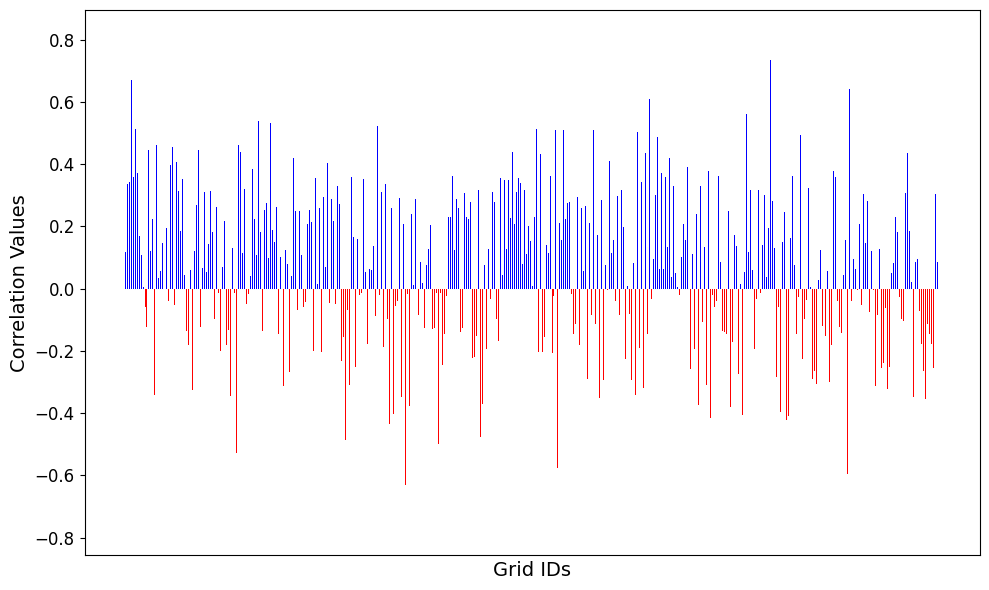

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with Pearson correlation coefficients
df = correlation_df

# Extracting grid IDs and their corresponding correlation values
grid_ids = df.index  # Assuming index holds grid IDs
correlation_values = df['Pearson Correlation']  # Replace 'Pearson Correlation' with the actual column name if different

# Define single shades for red and blue
single_red = '#FF0000'  # Pure red
single_blue = '#0000FF'  # Pure blue

# Assign colors based on positive (blue) and negative (red) values
colors = np.where(correlation_values < 0, single_red, single_blue)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(grid_ids, correlation_values, color=colors, width=0.5)

# Customizing x-axis and y-axis labels and tick sizes
plt.xticks([])
plt.yticks(fontsize=12)               # Set y-axis tick fontsize
plt.xlabel('Grid IDs', fontsize=14)
plt.ylabel('Correlation Values', fontsize=14)

# Ensure the plot layout is tight and save/show the plot
plt.tight_layout()  # Ensures the labels fit properly
plt.savefig('correlation.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [4]:
grid_id = []
for i in range(len(correlation_df)):
    if correlation_df.iloc[i, 0] < 0:
        grid_id.append(i)

print(len(correlation_df))
print(len(grid_id))

55767
23830


In [13]:
import geopandas as gpd

# List of interested grid_ids
interested_grid_ids = grid_id  # replace with your actual list

# Load the GeoJSON file
gdf = gpd.read_file('/home/sie/Documents/Research_1/Code/pop_himachal/mean_population_2002_chunk_0.geojson')

# Filter the DataFrame based on interested grid_ids
filtered_gdf = gdf[gdf['FID'].isin(interested_grid_ids)]

# Save the filtered GeoDataFrame to a new GeoJSON file
filtered_gdf.to_file('filtered_grids_-30.geojson', driver='GeoJSON')

print("Filtered GeoJSON file saved as 'filtered_grids.geojson'")


Filtered GeoJSON file saved as 'filtered_grids.geojson'


## Final Results

### Pop and EVI joint prediction

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import LSTM, Linear
from torch_geometric.nn import GATConv
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import wandb

def prepare_time_series_data(df, sequence_length):
    """
    Prepare time series data for the LSTM model.
    """
    n_timesteps, n_grids, n_features = df.shape

    X = np.zeros((n_timesteps - sequence_length, sequence_length, n_grids, n_features))
    y = np.zeros((n_timesteps - sequence_length, n_grids, n_features))

    for i in range(n_timesteps - sequence_length):
        X[i] = df[i:i+sequence_length]
        y[i] = df[i+sequence_length]

    return X, y


class SpatioTemporalGATLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.gat_heads = gat_heads
        self.sequence_length = sequence_length

        self.gat1 = GATConv(in_channels, hidden_channels, heads=gat_heads, dropout=0.5)
        self.gat2 = GATConv(hidden_channels * gat_heads, hidden_channels, heads=gat_heads, dropout=0.5)
        self.lstm = LSTM(hidden_channels * gat_heads, hidden_channels, num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # x shape: [batch_size, sequence_length, num_nodes, in_channels]
        num_samples, seq_len, num_nodes, _ = x.size()

        # Initialize a list to store GAT outputs for each time step
        gat_outputs = []

        # Process each time step independently through the GATConv layer
        for t in range(seq_len):
            xt = x[:, t, :]  # Shape: [batch_size, num_nodes, in_channels]
            xt = xt.reshape(num_samples * num_nodes, self.in_channels)  # Flatten the batch and nodes

            # Apply GAT
            xt = self.gat1(xt, edge_index)  # Shape: [batch_size * num_nodes, hidden_channels * gat_heads]
            xt = F.elu(xt)

            xt = self.gat2(xt, edge_index)
            xt = F.elu(xt)

            # Reshape back to [batch_size, num_nodes, hidden_channels * gat_heads]
            xt = xt.view(num_samples, num_nodes, -1)
            gat_outputs.append(xt)

        # Stack the GAT outputs along the time dimension
        x = torch.stack(gat_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels * gat_heads]

        # Prepare for LSTM
        x = x.permute(0, 2, 1, 3).contiguous()  # Shape: [batch_size, num_nodes, sequence_length, hidden_channels * gat_heads]
        x = x.view(num_samples * num_nodes, seq_len, -1)  # Shape: [batch_size * num_nodes, sequence_length, hidden_channels * gat_heads]

        # Apply LSTM
        x, _ = self.lstm(x)

        # Take the last output of LSTM
        x = x[:, -1, :]  # Shape: [batch_size * num_nodes, hidden_channels]

        # Apply final linear layer
        x = self.linear(x)  # Shape: [batch_size * num_nodes, out_channels]

        # Reshape back to [batch_size, num_nodes, out_channels]
        x = x.view(num_samples, num_nodes, -1)

        return x

# class SpatioTemporalGATLSTM(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
#         super().__init__()
#         self.lstm = LSTM(in_channels, hidden_channels, num_layers=lstm_layers, batch_first=True)
#         self.linear = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         num_samples, seq_len, num_nodes, _ = x.size()
#         x = x.permute(0, 2, 1, 3).contiguous()
#         x = x.view(num_samples * num_nodes, seq_len, -1)

#         x, _ = self.lstm(x)
#         x = x[:, -1, :]
#         x = self.linear(x)
#         x = x.view(num_samples, num_nodes, -1)
#         return x

def train_epoch(model, data_loader, edge_index, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X, edge_index.to(device))
        loss = F.mse_loss(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def validate(model, data_loader, edge_index, scheduler, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            out = model(batch_X, edge_index.to(device))
            loss = F.mse_loss(out, batch_y)
            total_loss += loss.item()
            scheduler.step(total_loss)
    return total_loss / len(data_loader)

def main():
    # Initialize wandb
    wandb.init(project="research", name="1")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Preparing data
    pop_df = pd.read_csv('pop_himachal.csv').drop('date', axis=1) 
    evi_df = pd.read_csv('evi_himachal.csv').drop('date', axis=1) 

    filtered_gdf = gpd.read_file('filtered_grids_mandi.geojson')
    filtered_grid_ids = filtered_gdf['FID'].tolist()
    filtered_grid_ids = list(map(str, filtered_grid_ids))
    
    df1 = pop_df[filtered_grid_ids]
    df2 = evi_df[filtered_grid_ids]

    num_rows, num_columns = df1.shape
    combined_array = np.zeros((num_rows, num_columns, 2), dtype=np.float32)
    combined_array[:, :, 0] = df1.values
    combined_array[:, :, 1] = df2.values

    print("Shape of the combined array:", combined_array.shape)

    X, y = prepare_time_series_data(combined_array, sequence_length=3)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
    print(f'Data Shapes - X: {X.shape}, y: {y.shape}')

    edge_index = np.loadtxt('edge_index_himachal.txt')
    edge_index = torch.tensor(edge_index, dtype=torch.int)
    print(f'edge_index shape: {edge_index.shape}')

    # Split data into train and validation sets chronologically
    total_samples = X.shape[0]
    train_size = int(0.9 * total_samples)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create DataLoaders for batch processing
    batch_size = 8  # Adjust this based on your GPU memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_samples, sequence_length, num_nodes, in_channels = X.size()
    hidden_channels, out_channels, lstm_layers = 8, 2, 2
    lr, epochs = 0.003, 500

    model = SpatioTemporalGATLSTM(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        gat_heads=4,
        lstm_layers=lstm_layers,
        sequence_length=sequence_length
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler: Reduce LR on plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.1, patience=10, 
                                                           threshold=1e-9, verbose=True)

    # Log model architecture and hyperparameters
    wandb.watch(model)
    wandb.config.update({
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_channels": hidden_channels,
        "lstm_layers": lstm_layers
    })

    best_val_loss = float('inf')

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, edge_index, optimizer, device)
        val_loss = validate(model, val_loader, edge_index, scheduler, device)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            'learning_rate': lr
        })

        # Save best model
        if epoch % 500 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            torch.save(model.state_dict(), f'best_model_{epoch}.pth')

    wandb.finish()

if __name__ == "__main__":
    main()

In [ ]:
## Training from last saved checkpoint

import torch
import torch.nn.functional as F
from torch.nn import LSTM, Linear
from torch_geometric.nn import GATConv
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import wandb

def prepare_time_series_data(df, sequence_length):
    """
    Prepare time series data for the LSTM model.
    """
    n_timesteps, n_grids, n_features = df.shape

    X = np.zeros((n_timesteps - sequence_length, sequence_length, n_grids, n_features))
    y = np.zeros((n_timesteps - sequence_length, n_grids, n_features))

    for i in range(n_timesteps - sequence_length):
        X[i] = df[i:i+sequence_length]
        y[i] = df[i+sequence_length]

    return X, y


class SpatioTemporalGATLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.gat_heads = gat_heads
        self.sequence_length = sequence_length

        self.gat1 = GATConv(in_channels, hidden_channels, heads=gat_heads, dropout=0.5)
        self.gat2 = GATConv(hidden_channels * gat_heads, hidden_channels, heads=gat_heads, dropout=0.5)
        self.lstm = LSTM(hidden_channels * gat_heads, hidden_channels, num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # x shape: [batch_size, sequence_length, num_nodes, in_channels]
        num_samples, seq_len, num_nodes, _ = x.size()

        # Initialize a list to store GAT outputs for each time step
        gat_outputs = []

        # Process each time step independently through the GATConv layer
        for t in range(seq_len):
            xt = x[:, t, :]  # Shape: [batch_size, num_nodes, in_channels]
            xt = xt.reshape(num_samples * num_nodes, self.in_channels)  # Flatten the batch and nodes

            # Apply GAT
            xt = self.gat1(xt, edge_index)  # Shape: [batch_size * num_nodes, hidden_channels * gat_heads]
            xt = F.elu(xt)

            xt = self.gat2(xt, edge_index)
            xt = F.elu(xt)

            # Reshape back to [batch_size, num_nodes, hidden_channels * gat_heads]
            xt = xt.view(num_samples, num_nodes, -1)
            gat_outputs.append(xt)

        # Stack the GAT outputs along the time dimension
        x = torch.stack(gat_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels * gat_heads]

        # Prepare for LSTM
        x = x.permute(0, 2, 1, 3).contiguous()  # Shape: [batch_size, num_nodes, sequence_length, hidden_channels * gat_heads]
        x = x.view(num_samples * num_nodes, seq_len, -1)  # Shape: [batch_size * num_nodes, sequence_length, hidden_channels * gat_heads]

        # Apply LSTM
        x, _ = self.lstm(x)

        # Take the last output of LSTM
        x = x[:, -1, :]  # Shape: [batch_size * num_nodes, hidden_channels]

        # Apply final linear layer
        x = self.linear(x)  # Shape: [batch_size * num_nodes, out_channels]

        # Reshape back to [batch_size, num_nodes, out_channels]
        x = x.view(num_samples, num_nodes, -1)

        return x

# class SpatioTemporalGATLSTM(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
#         super().__init__()
#         self.lstm = LSTM(in_channels, hidden_channels, num_layers=lstm_layers, batch_first=True)
#         self.linear = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         num_samples, seq_len, num_nodes, _ = x.size()
#         x = x.permute(0, 2, 1, 3).contiguous()
#         x = x.view(num_samples * num_nodes, seq_len, -1)

#         x, _ = self.lstm(x)
#         x = x[:, -1, :]
#         x = self.linear(x)
#         x = x.view(num_samples, num_nodes, -1)
#         return x

def train_epoch(model, data_loader, edge_index, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X, edge_index.to(device))
        loss = F.mse_loss(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def validate(model, data_loader, edge_index, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            out = model(batch_X, edge_index.to(device))
            loss = F.mse_loss(out, batch_y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def main():
    # Initialize wandb
    wandb.init(project="", name="2")
    # wandb.init(project="spatiotemporal-lstm", name="experiment-1")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Preparing data
    pop_df = pd.read_csv('pop_himachal.csv')
    evi_df = pd.read_csv('evi_himachal_monthly.csv')
    df1 = pop_df.drop('date', axis=1), 
    df2 = evi_df.drop('date', axis=1)

    num_rows, num_columns = df1.shape
    combined_array = np.zeros((num_rows, num_columns, 2), dtype=np.float32)
    combined_array[:, :, 0] = df1.values
    combined_array[:, :, 1] = df2.values

    print("Shape of the combined array:", combined_array.shape)

    X, y = prepare_time_series_data(combined_array, sequence_length=6)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
    print(f'Data Shapes - X: {X.shape}, y: {y.shape}')

    edge_index = np.loadtxt('edge_index_himachal.txt')
    edge_index = torch.tensor(edge_index, dtype=torch.int)
    print(f'edge_index shape: {edge_index.shape}')

    # Split data into train and validation sets chronologically
    total_samples = X.shape[0]
    train_size = int(0.8 * total_samples)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create DataLoaders for batch processing
    batch_size = 8  # Adjust this based on your GPU memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_samples, sequence_length, num_nodes, in_channels = X.size()
    hidden_channels, out_channels, lstm_layers = 8, 1, 2
    lr, epochs = 0.001, 500

    model = SpatioTemporalGATLSTM(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        gat_heads=4,
        lstm_layers=lstm_layers,
        sequence_length=sequence_length
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-9)


    # Load the saved model from the checkpoint
    model.load_state_dict(torch.load('best_model_1000.pth'))

    # Log model architecture and hyperparameters
    wandb.watch(model)
    wandb.config.update({
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_channels": hidden_channels,
        "lstm_layers": lstm_layers
    })

    best_val_loss = float('inf')

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, edge_index, optimizer, device)
        val_loss = validate(model, val_loader, edge_index, device)

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        # Save best model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model_1001.pth')
            # wandb.save('best_model_lstm.pth')

    wandb.finish()

if __name__ == "__main__":
    main()

In [17]:
## Predicting future time steps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing data
pop_df = pd.read_csv('pop_himachal.csv')
evi_df = pd.read_csv('evi_himachal.csv')
df1, df2 = pop_df.drop('date', axis=1), evi_df.drop('date', axis=1)

# Get the shape of the dataframes
num_rows, num_columns = df1.shape

# Create the new combined array
combined_array = np.zeros((num_rows, num_columns, 2), dtype=object)

# Fill the combined array
for i in range(num_rows):
    for j in range(num_columns):
        combined_array[i, j, 0] = df1.iloc[i, j]
        combined_array[i, j, 1] = df2.iloc[i, j]

# Print the shape of the combined array
print("Shape of the combined array:", combined_array.shape)
combined_array = combined_array[:8]
X, y = prepare_time_series_data(combined_array, sequence_length=3)
# X, y = np.expand_dims(X, axis=-1), np.expand_dims(y, axis=-1)
X, y = torch.from_numpy(X).to(torch.float32), torch.from_numpy(y).to(torch.float32)
print(f'Data Shapes', X.shape, y.shape)

edge_index = np.loadtxt('edge_index_himachal.txt')
edge_index = torch.tensor(edge_index, dtype=torch.int)
print(f'edge_index shape: {edge_index.shape}')

num_samples, sequence_length, num_nodes, in_channels = X.size()
hidden_channels, out_channels, gat_heads, lstm_layers = 8, 2, 4, 2
lr, epochs = 0.0002, 100


# Define model, optimizer, and loss function
model = SpatioTemporalGATLSTM(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    gat_heads=4,
    lstm_layers=lstm_layers,
    sequence_length=sequence_length
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-9)


# Load the saved model from the checkpoint
model.load_state_dict(torch.load('best_model_2000.pth'))
model.eval()  # Set the model to evaluation mode

# Define the number of future timesteps to predict
future_timesteps = 20

# Assuming the last few timesteps in your data are the input for prediction
# You can take the last `sequence_length` timesteps from your combined data
X_input = X[-1].unsqueeze(0).to(device)  # Adding a batch dimension
print('X_input shape', X_input.shape)
# Initialize an empty list to store predictions
predictions = []

# Generate predictions for the next 20 timesteps
with torch.no_grad():  # No need to compute gradients during inference
    for t in range(future_timesteps):
        out = model(X_input.to(device), edge_index.to(device))
        predictions.append(out.cpu().numpy())  # Store the prediction

        # Update the input by appending the predicted value
        # and removing the oldest timestep from the sequence
        X_input = torch.cat((X_input[:, 1:, :, :], out.unsqueeze(1)), dim=1)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Print the shape of the predictions
print("Predictions shape:", predictions.shape)

# Optionally, you can save the predictions to a file for further analysis
np.save('predicted_timesteps.npy', predictions)

Shape of the combined array: (19, 55767, 2)
Data Shapes torch.Size([5, 3, 55767, 2]) torch.Size([5, 55767, 2])
edge_index shape: torch.Size([2, 496539])
X_input shape torch.Size([1, 3, 55767, 2])
Predictions shape: (20, 1, 55767, 2)


In [20]:
## Save predictions to geojson file

import geopandas as gpd
import numpy as np

def replace_geojson_values(input_file, output_file, new_values):
    # Load the GeoJSON file
    gdf = gpd.read_file(input_file)

    # Ensure the number of new values matches the number of features
    if len(new_values) != len(gdf):
        raise ValueError("The number of new values must match the number of features in the GeoJSON file.")

    # Replace the values in a specified column (e.g., 'value')
    # If 'value' column doesn't exist, it will be created
    gdf['mean_population'] = new_values

    # Save the modified GeoJSON to a new file
    gdf.to_file(output_file, driver='GeoJSON')

    print(f"Modified GeoJSON saved to {output_file}")

# Example usage
if __name__ == "__main__":
    input_file = "pop_himachal/mean_population_2002_chunk_0.geojson"

    replace_geojson_values(input_file, 'pop_himachal/mean_population_2030_chunk_0.geojson', predictions[1, :, :, 0][0])
    replace_geojson_values(input_file, 'pop_himachal/mean_population_2040_chunk_0.geojson', predictions[5, :, :, 0][0])
    replace_geojson_values(input_file, 'pop_himachal/mean_population_2050_chunk_0.geojson', predictions[15, :, :, 0][0])

Modified GeoJSON saved to pop_himachal/mean_population_2030_chunk_0.geojson
Modified GeoJSON saved to pop_himachal/mean_population_2040_chunk_0.geojson
Modified GeoJSON saved to pop_himachal/mean_population_2050_chunk_0.geojson


In [21]:
## Save predictions to geojson file

import geopandas as gpd
import numpy as np

def replace_geojson_values(input_file, output_file, new_values):
    # Load the GeoJSON file
    gdf = gpd.read_file(input_file)

    # Ensure the number of new values matches the number of features
    if len(new_values) != len(gdf):
        raise ValueError("The number of new values must match the number of features in the GeoJSON file.")

    # Replace the values in a specified column (e.g., 'value')
    # If 'value' column doesn't exist, it will be created
    gdf['mean_evi'] = new_values

    # Save the modified GeoJSON to a new file
    gdf.to_file(output_file, driver='GeoJSON')

    print(f"Modified GeoJSON saved to {output_file}")

# Example usage
if __name__ == "__main__":
    input_file = "evi_himachal/mean_evi_2002_06_chunk_0.geojson"

    replace_geojson_values(input_file, 'evi_himachal/mean_evi_2030_06_chunk_0.geojson', predictions[1, :, :, 1][0])
    replace_geojson_values(input_file, 'evi_himachal/mean_evi_2040_06_chunk_0.geojson', predictions[5, :, :, 1][0])
    replace_geojson_values(input_file, 'evi_himachal/mean_evi_2050_06_chunk_0.geojson', predictions[11, :, :, 1][0])

Modified GeoJSON saved to evi_himachal/mean_evi_2030_06_chunk_0.geojson
Modified GeoJSON saved to evi_himachal/mean_evi_2040_06_chunk_0.geojson
Modified GeoJSON saved to evi_himachal/mean_evi_2050_06_chunk_0.geojson


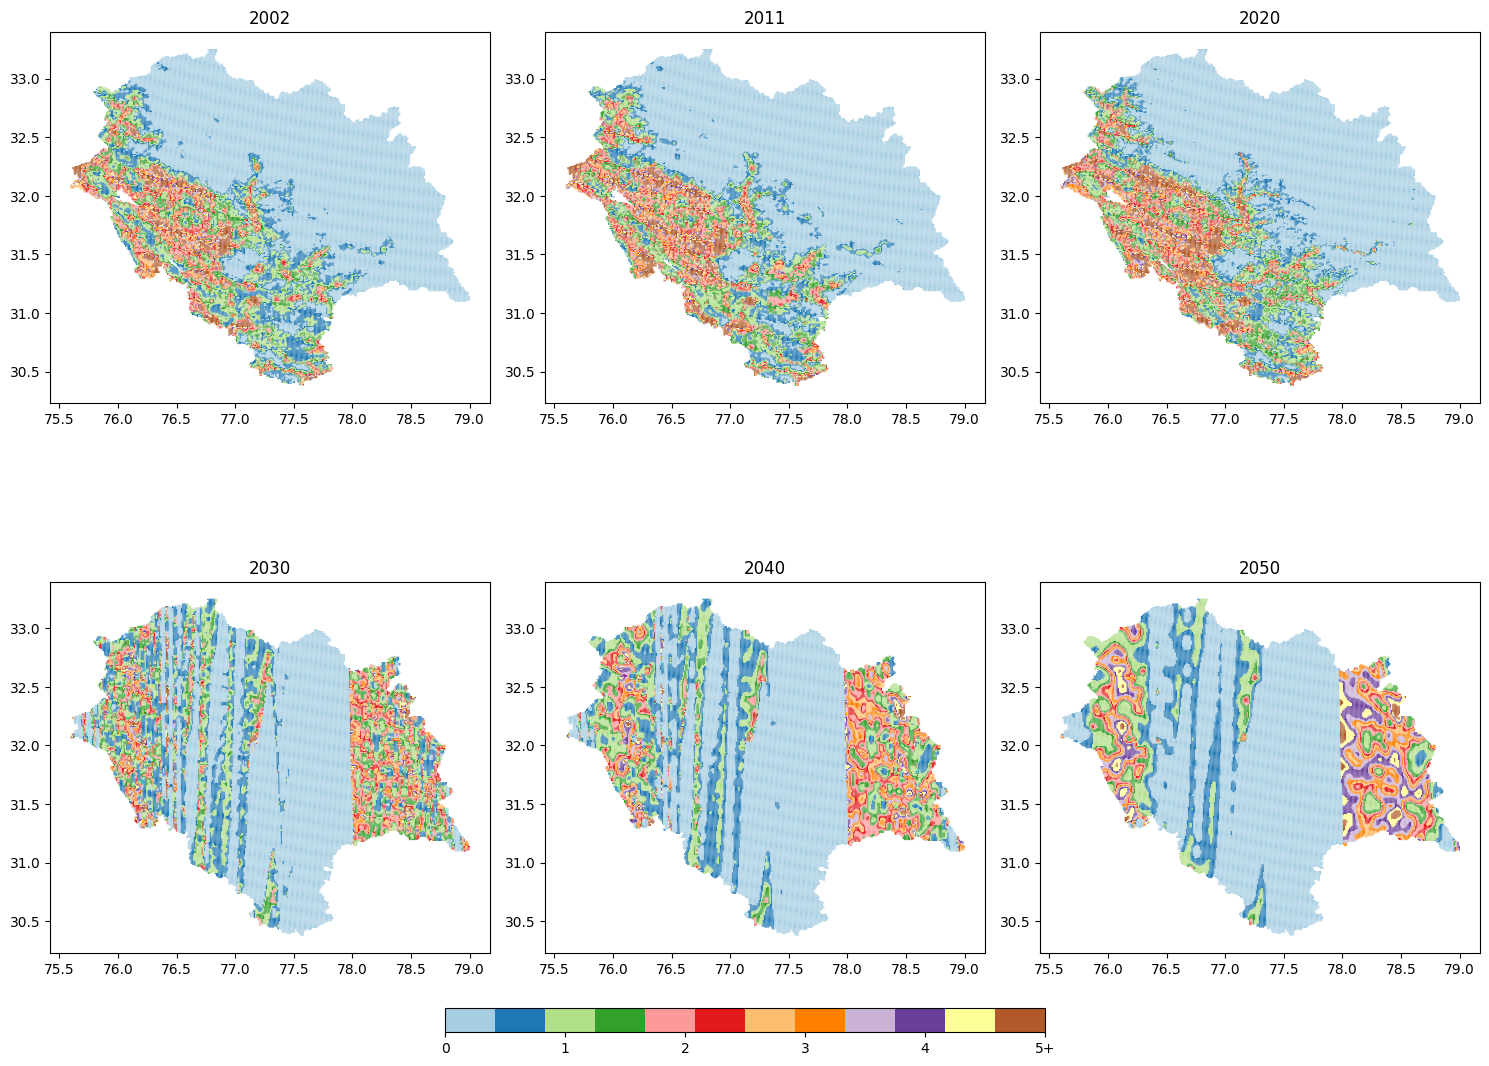

In [22]:
## For pop plot

import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = 'pop_himachal/'

# Get list of GeoJSON files in the directory
geojson_files = ['mean_population_2002_chunk_0.geojson',
                'mean_population_2011_chunk_0.geojson',
                'mean_population_2020_chunk_0.geojson',
                 'mean_population_2030_chunk_0.geojson',
                'mean_population_2040_chunk_0.geojson',
                'mean_population_2050_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'mean_population_2002_chunk_0.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 3
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows + 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 5  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)

    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]

    # Plot each filtered GeoDataFrame in the corresponding subplot
    gdf.plot(column='mean_population', cmap='Paired', ax=axes[i], norm=norm, aspect='equal')
    axes[i].set_title(file_name.split('_')[2])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure even spacing and prevent overlap
plt.tight_layout()

# Add a common colorbar at the bottom with added space
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])  # Adjusted for bottom placement
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels (for example, 25 custom labels)
custom_labels = ['0', '1', '2', '3', '4', '5+']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('pop_raster_himachal_2k.pdf', format='pdf')
plt.show()

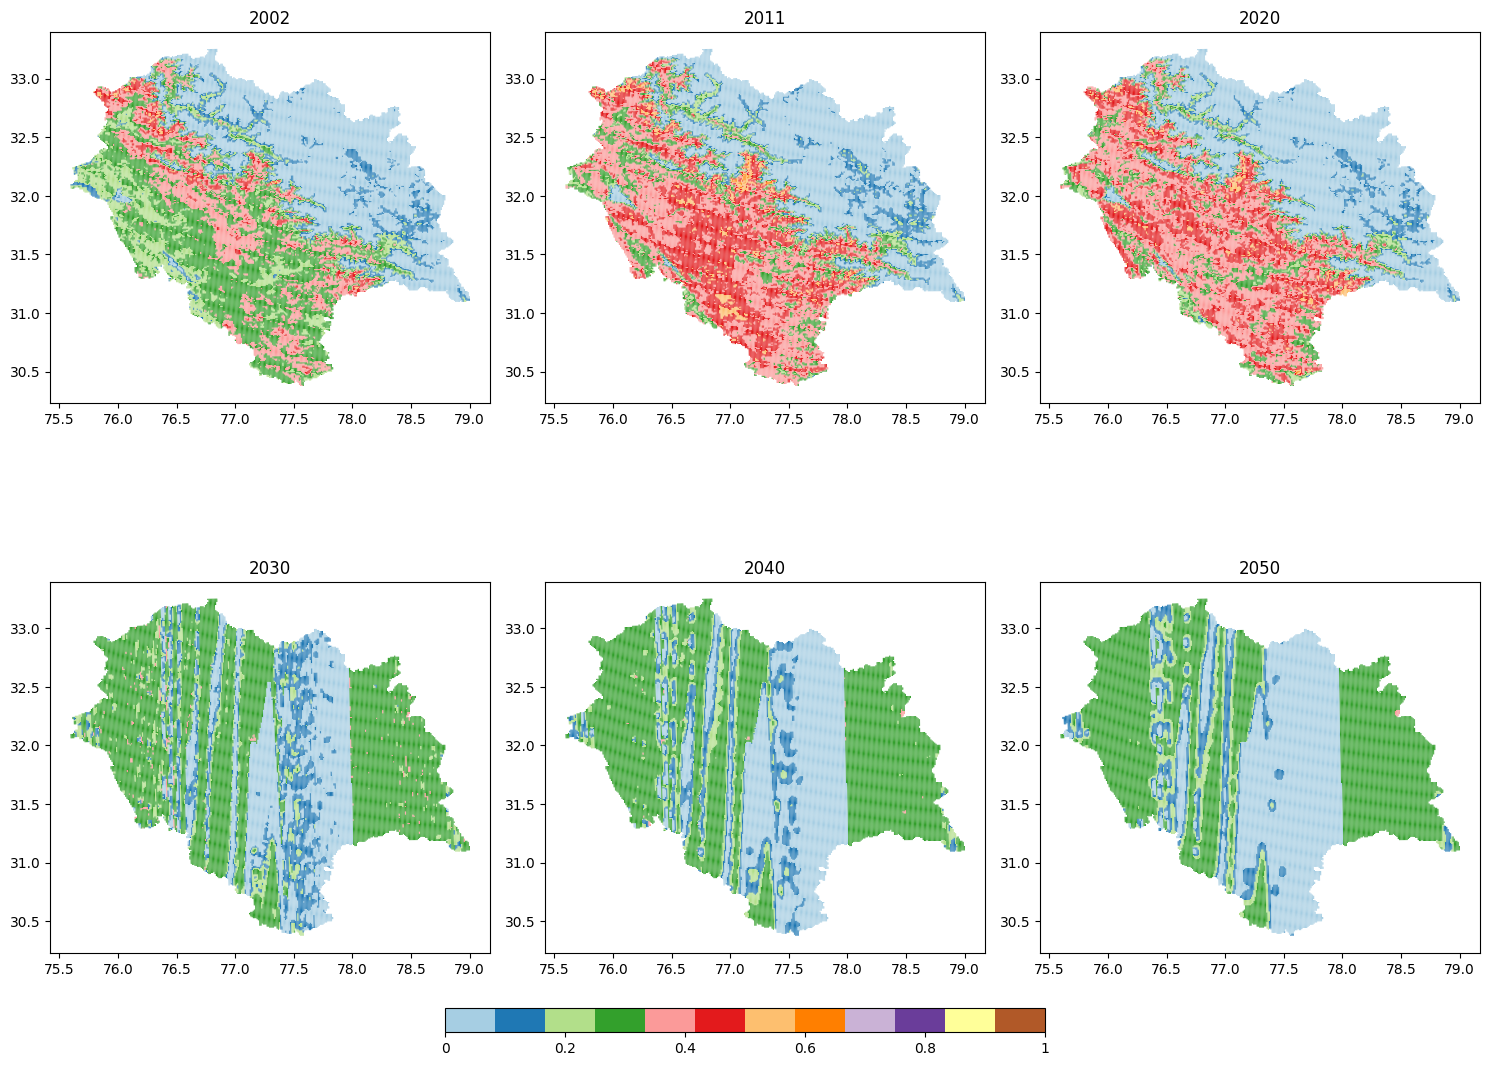

In [23]:
## For evi plot

import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = 'evi_himachal/'

# Get list of GeoJSON files in the directory
geojson_files = ['mean_evi_2002_06_chunk_0.geojson',
                'mean_evi_2011_06_chunk_0.geojson',
                'mean_evi_2020_06_chunk_0.geojson',
                'mean_evi_2030_06_chunk_0.geojson',
                'mean_evi_2040_06_chunk_0.geojson',
                'mean_evi_2050_06_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'mean_evi_2002_06_chunk_0.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 3
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows + 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 1  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)

    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]

    # Plot each filtered GeoDataFrame in the corresponding subplot
    gdf.plot(column='mean_evi', cmap='Paired', ax=axes[i], norm=norm, aspect='equal')
    axes[i].set_title(file_name.split('_')[2])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure even spacing and prevent overlap
plt.tight_layout()

# Add a common colorbar at the bottom with added space
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])  # Adjusted for bottom placement
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels (for example, 25 custom labels)
custom_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('evi_raster_himachal.pdf', format='pdf')
plt.show()

In [ ]:
## Plot trends and predictions for monthly data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('evi_shimla.csv', index_col=0, parse_dates=True)

# Save the original datetime index to a list
date_time_index = df.index.tolist()

# Convert the DataFrame index to a numerical range
df.reset_index(drop=True, inplace=True)

def plot_forecast_with_trend(grid_id, y_test, y_pred):
    """Plot the complete time series with trend lines and highlight the last 52 timesteps as the forecasted period."""
    plt.figure(figsize=(18, 10))

    # Determine the start index for the forecast period (last 52 timesteps)
    start_forecast_index = len(df) - 52

    # Ensure grid_id is a string for DataFrame indexing
    grid_id_str = str(grid_id)

    # Check if the grid_id exists in the DataFrame
    if grid_id_str not in df.columns:
        print(f"Grid ID {grid_id_str} not found in the DataFrame")
        return

    # Get the actual values for the entire series
    actual_values = df[grid_id_str].values

    # Plot the actual values for the entire time series
    plt.plot(date_time_index, actual_values, label='Actual', color='blue', alpha=0.7)

    # Plot the forecasted period (last 52 timesteps)
    if y_test is not None and y_pred is not None:
        plt.plot(date_time_index[start_forecast_index:], y_test[:, df.columns.get_loc(grid_id_str)], label='Test', color='orange')
        plt.plot(date_time_index[start_forecast_index:], y_pred[:, df.columns.get_loc(grid_id_str)], label='Prediction', color='red')

    # Calculate and plot rolling average trend for the entire series
    window_size = 12  # 12 months for yearly seasonality
    rolling_mean = pd.Series(actual_values).rolling(window=window_size, center=True).mean()
    plt.plot(date_time_index, rolling_mean, label='Rolling Average Trend', color='green', linewidth=2)

    # Calculate and plot polynomial trend for the entire series
    x = np.arange(len(actual_values))
    z = np.polyfit(x, actual_values, 3)
    p = np.poly1d(z)
    plt.plot(date_time_index, p(x), label='Polynomial Trend', color='purple', linewidth=2)

    # Highlight the forecasted area
    plt.axvspan(date_time_index[start_forecast_index], date_time_index[-1], color='lightgreen', alpha=0.3, label='Forecast Period')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('EVI Values')
    plt.title(f'Time Series Forecasting with Trend for Grid {grid_id_str}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print debugging information
    print(f"Actual values range: {np.min(actual_values)} to {np.max(actual_values)}")
    print(f"Rolling mean range: {np.min(rolling_mean)} to {np.max(rolling_mean)}")
    print(f"Polynomial trend range: {np.min(p(x))} to {np.max(p(x))}")

# Example usage

grid_id = np.random.randint(0, 1707)  # Replace with the grid ID you want to plot

# Assuming y_test and y_pred are numpy arrays with shape (52, number_of_grids)
# Make sure these are defined before calling plot_forecast_with_trend
y_test = y_test
y_pred = predictions

plot_forecast_with_trend(grid_id, y_test, y_pred)


### EVI or Pop seperate predictions

In [72]:
import torch
import torch.nn.functional as F
from torch.nn import LSTM, Linear
from torch_geometric.nn import GATConv
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import wandb

torch.cuda.empty_cache()

def prepare_time_series_data(df, sequence_length):
    """
    Prepare time series data for the LSTM model.
    """
    n_timesteps, n_grids, n_features = df.shape

    X = np.zeros((n_timesteps - sequence_length, sequence_length, n_grids, n_features))
    y = np.zeros((n_timesteps - sequence_length, n_grids, n_features))

    for i in range(n_timesteps - sequence_length):
        X[i] = df[i:i+sequence_length]
        y[i] = df[i+sequence_length]

    return X, y


# class SpatioTemporalGATLSTM(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
#         super().__init__()
#         self.in_channels = in_channels
#         self.hidden_channels = hidden_channels
#         self.out_channels = out_channels
#         self.gat_heads = gat_heads
#         self.sequence_length = sequence_length

#         self.gat1 = GATConv(in_channels, hidden_channels, heads=gat_heads, dropout=0.5)
#         self.gat2 = GATConv(hidden_channels * gat_heads, hidden_channels, heads=gat_heads, dropout=0.5)
#         self.lstm = LSTM(hidden_channels * gat_heads, hidden_channels, num_layers=lstm_layers, batch_first=True)
#         self.linear = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         # x shape: [batch_size, sequence_length, num_nodes, in_channels]
#         num_samples, seq_len, num_nodes, _ = x.size()

#         # Initialize a list to store GAT outputs for each time step
#         gat_outputs = []

#         # Process each time step independently through the GATConv layer
#         for t in range(seq_len):
#             xt = x[:, t, :]  # Shape: [batch_size, num_nodes, in_channels]
#             xt = xt.reshape(num_samples * num_nodes, self.in_channels)  # Flatten the batch and nodes

#             # Apply GAT
#             xt = self.gat1(xt, edge_index)  # Shape: [batch_size * num_nodes, hidden_channels * gat_heads]
#             xt = F.elu(xt)

#             xt = self.gat2(xt, edge_index)
#             xt = F.elu(xt)

#             # Reshape back to [batch_size, num_nodes, hidden_channels * gat_heads]
#             xt = xt.view(num_samples, num_nodes, -1)
#             gat_outputs.append(xt)

#         # Stack the GAT outputs along the time dimension
#         x = torch.stack(gat_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels * gat_heads]

#         # Prepare for LSTM
#         x = x.permute(0, 2, 1, 3).contiguous()  # Shape: [batch_size, num_nodes, sequence_length, hidden_channels * gat_heads]
#         x = x.view(num_samples * num_nodes, seq_len, -1)  # Shape: [batch_size * num_nodes, sequence_length, hidden_channels * gat_heads]

#         # Apply LSTM
#         x, _ = self.lstm(x)

#         # Take the last output of LSTM
#         x = x[:, -1, :]  # Shape: [batch_size * num_nodes, hidden_channels]

#         # Apply final linear layer
#         x = self.linear(x)  # Shape: [batch_size * num_nodes, out_channels]

#         # Reshape back to [batch_size, num_nodes, out_channels]
#         x = x.view(num_samples, num_nodes, -1)

#         return x

class SpatioTemporalGATLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
        super().__init__()
        self.lstm = LSTM(in_channels, hidden_channels, num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        num_samples, seq_len, num_nodes, _ = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(num_samples * num_nodes, seq_len, -1)

        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(num_samples, num_nodes, -1)
        return x

def train_epoch(model, data_loader, edge_index, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X, edge_index.to(device))
        loss = F.mse_loss(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def validate(model, data_loader, edge_index, scheduler, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            out = model(batch_X, edge_index.to(device))
            loss = F.mse_loss(out, batch_y)
            total_loss += loss.item()
            scheduler.step(total_loss)
    return total_loss / len(data_loader)

def main():
    # Initialize wandb
    wandb.init(project="param", name="mandi")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Preparing data
    pop_df = pd.read_csv('pop_himachal.csv')
    evi_df = pd.read_csv('evi_himachal_monthly.csv')
    filtered_gdf = gpd.read_file('filtered_grids_mandi.geojson')
    filtered_grid_ids = filtered_gdf['FID'].tolist()
    filtered_grid_ids = list(map(str, filtered_grid_ids))

    # Filter the evi_df DataFrame to include only columns that match the filtered grid IDs
    df1 = pop_df[filtered_grid_ids]
    df2 = evi_df[filtered_grid_ids]


    num_rows, num_columns = df2.shape
    combined_array = np.zeros((num_rows, num_columns, 1), dtype=np.float32)
    # combined_array[:, :, 0] = df1.values
    combined_array[:, :, 0] = df2.values

    print("Shape of the combined array:", combined_array.shape)

    X, y = prepare_time_series_data(combined_array, sequence_length=6)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
    print(f'Data Shapes - X: {X.shape}, y: {y.shape}')

    edge_index = np.loadtxt('edge_index_mandi.txt')
    edge_index = torch.tensor(edge_index, dtype=torch.int)
    print(f'edge_index shape: {edge_index.shape}')

    # Split data into train and validation sets chronologically
    total_samples = X.shape[0]
    train_size = int(0.9 * total_samples)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create DataLoaders for batch processing
    batch_size = 32  # Adjust this based on your GPU memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_samples, sequence_length, num_nodes, in_channels = X.size()
    hidden_channels, out_channels, lstm_layers, gat_heads = 8, 1, 2, 4
    lr, epochs = 0.003, 800

    model = SpatioTemporalGATLSTM(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        gat_heads=gat_heads,
        lstm_layers=lstm_layers,
        sequence_length=sequence_length
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler: Reduce LR on plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.1, patience=10, 
                                                           threshold=1e-9, verbose=True)

    # Log model architecture and hyperparameters
    wandb.watch(model)
    wandb.config.update({
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_channels": hidden_channels,
        "lstm_layers": lstm_layers
    })

    best_val_loss = float('inf')

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, edge_index, optimizer, device)
        val_loss = validate(model, val_loader, edge_index, scheduler, device)
        # print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            'learning_rate': lr
        })

        if epoch % 400 == 0:
          print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
          torch.save(model.state_dict(), f'gat_mandi_{epoch}.pth')

    wandb.finish()

if __name__ == "__main__":
    main()

Using device: cuda
Shape of the combined array: (264, 4068, 1)
Data Shapes - X: torch.Size([258, 6, 4068, 1]), y: torch.Size([258, 4068, 1])
edge_index shape: torch.Size([2, 35714])
Epoch: 400, Train Loss: 0.0039, Val Loss: 0.0031
Epoch 00753: reducing learning rate of group 0 to 3.0000e-04.
Epoch 00764: reducing learning rate of group 0 to 3.0000e-05.
Epoch 00775: reducing learning rate of group 0 to 3.0000e-06.
Epoch 00786: reducing learning rate of group 0 to 3.0000e-07.
Epoch 00797: reducing learning rate of group 0 to 3.0000e-08.
Epoch: 800, Train Loss: 0.0038, Val Loss: 0.0032


In [74]:
## Predicting future time steps

import torch
import torch.nn.functional as F
from torch.nn import LSTM, Linear
from torch_geometric.nn import GATConv
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing data

def prepare_time_series_data(df, sequence_length):
    """
    Prepare time series data for the LSTM model.
    """
    n_timesteps, n_grids, n_features = df.shape

    X = np.zeros((n_timesteps - sequence_length, sequence_length, n_grids, n_features))
    y = np.zeros((n_timesteps - sequence_length, n_grids, n_features))

    for i in range(n_timesteps - sequence_length):
        X[i] = df[i:i+sequence_length]
        y[i] = df[i+sequence_length]

    return X, y

# class SpatioTemporalGATLSTM(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
#         super().__init__()
#         self.in_channels = in_channels
#         self.hidden_channels = hidden_channels
#         self.out_channels = out_channels
#         self.gat_heads = gat_heads
#         self.sequence_length = sequence_length

#         self.gat1 = GATConv(in_channels, hidden_channels, heads=gat_heads, dropout=0.5)
#         self.gat2 = GATConv(hidden_channels * gat_heads, hidden_channels, heads=gat_heads, dropout=0.5)
#         self.lstm = LSTM(hidden_channels * gat_heads, hidden_channels, num_layers=lstm_layers, batch_first=True)
#         self.linear = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         # x shape: [batch_size, sequence_length, num_nodes, in_channels]
#         num_samples, seq_len, num_nodes, _ = x.size()

#         # Initialize a list to store GAT outputs for each time step
#         gat_outputs = []

#         # Process each time step independently through the GATConv layer
#         for t in range(seq_len):
#             xt = x[:, t, :]  # Shape: [batch_size, num_nodes, in_channels]
#             xt = xt.reshape(num_samples * num_nodes, self.in_channels)  # Flatten the batch and nodes

#             # Apply GAT
#             xt = self.gat1(xt, edge_index)  # Shape: [batch_size * num_nodes, hidden_channels * gat_heads]
#             xt = F.elu(xt)

#             xt = self.gat2(xt, edge_index)
#             xt = F.elu(xt)

#             # Reshape back to [batch_size, num_nodes, hidden_channels * gat_heads]
#             xt = xt.view(num_samples, num_nodes, -1)
#             gat_outputs.append(xt)

#         # Stack the GAT outputs along the time dimension
#         x = torch.stack(gat_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels * gat_heads]

#         # Prepare for LSTM
#         x = x.permute(0, 2, 1, 3).contiguous()  # Shape: [batch_size, num_nodes, sequence_length, hidden_channels * gat_heads]
#         x = x.view(num_samples * num_nodes, seq_len, -1)  # Shape: [batch_size * num_nodes, sequence_length, hidden_channels * gat_heads]

#         # Apply LSTM
#         x, _ = self.lstm(x)

#         # Take the last output of LSTM
#         x = x[:, -1, :]  # Shape: [batch_size * num_nodes, hidden_channels]

#         # Apply final linear layer
#         x = self.linear(x)  # Shape: [batch_size * num_nodes, out_channels]

#         # Reshape back to [batch_size, num_nodes, out_channels]
#         x = x.view(num_samples, num_nodes, -1)

#         return x

class SpatioTemporalGATLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gat_heads, lstm_layers, sequence_length):
        super().__init__()
        self.lstm = LSTM(in_channels, hidden_channels, num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        num_samples, seq_len, num_nodes, _ = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(num_samples * num_nodes, seq_len, -1)

        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(num_samples, num_nodes, -1)
        return x
        
# Preparing data
pop_df = pd.read_csv('pop_himachal.csv')
evi_df = pd.read_csv('evi_himachal.csv')
filtered_gdf = gpd.read_file('filtered_grids_mandi.geojson')
filtered_grid_ids = filtered_gdf['FID'].tolist()
filtered_grid_ids = list(map(str, filtered_grid_ids))

# Filter the evi_df DataFrame to include only columns that match the filtered grid IDs
df1 = pop_df[filtered_grid_ids]
df2 = evi_df[filtered_grid_ids]


num_rows, num_columns = df2.shape
combined_array = np.zeros((num_rows, num_columns, 1), dtype=np.float32)
# combined_array[:, :, 0] = df1.values
combined_array[:, :, 0] = df2.values

print("Shape of the combined array:", combined_array.shape)

X, y = prepare_time_series_data(combined_array, sequence_length=6)
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
print(f'Data Shapes - X: {X.shape}, y: {y.shape}')

edge_index = np.loadtxt('edge_index_mandi.txt')
edge_index = torch.tensor(edge_index, dtype=torch.int)
print(f'edge_index shape: {edge_index.shape}')

num_samples, sequence_length, num_nodes, in_channels = X.size()
hidden_channels, out_channels, lstm_layers, gat_heads = 8, 1, 2, 4
lr, epochs = 0.0003, 2000

model = SpatioTemporalGATLSTM(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    gat_heads=gat_heads,
    lstm_layers=lstm_layers,
    sequence_length=sequence_length
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


# Load the saved model from the checkpoint
model.load_state_dict(torch.load('gat_mandi_800.pth'))
model.eval()  # Set the model to evaluation mode

# Define the number of future timesteps to predict
future_timesteps = 20

# Assuming the last few timesteps in your data are the input for prediction
# You can take the last `sequence_length` timesteps from your combined data
X_input = X[-1].unsqueeze(0).to(device)  # Adding a batch dimension
print('X_input shape', X_input.shape)
# Initialize an empty list to store predictions
predictions = []

# Generate predictions for the next 20 timesteps
with torch.no_grad():  # No need to compute gradients during inference
    for t in range(future_timesteps):
        out = model(X_input.to(device), edge_index.to(device))
        predictions.append(out.cpu().numpy())  # Store the prediction

        # Update the input by appending the predicted value
        # and removing the oldest timestep from the sequence
        X_input = torch.cat((X_input[:, 1:, :, :], out.unsqueeze(1)), dim=1)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Print the shape of the predictions
print("Predictions shape:", predictions.shape)

# Optionally, you can save the predictions to a file for further analysis
np.save('predicted_evi_timesteps.npy', predictions)

Shape of the combined array: (19, 4068, 1)
Data Shapes - X: torch.Size([13, 6, 4068, 1]), y: torch.Size([13, 4068, 1])
edge_index shape: torch.Size([2, 35714])
X_input shape torch.Size([1, 6, 4068, 1])
Predictions shape: (20, 1, 4068, 1)


In [75]:
## Save predictions to geojson file

import geopandas as gpd
import numpy as np

def replace_geojson_values(input_file, output_file, new_values):
    # Load the GeoJSON file
    gdf = gpd.read_file(input_file)

    # Ensure the number of new values matches the number of features
    if len(new_values) != len(gdf):
        raise ValueError("The number of new values must match the number of features in the GeoJSON file.")

    # Replace the values in a specified column (e.g., 'value')
    # If 'value' column doesn't exist, it will be created
    gdf['mean_evi'] = new_values

    # Save the modified GeoJSON to a new file
    gdf.to_file(output_file, driver='GeoJSON')

    print(f"Modified GeoJSON saved to {output_file}")

# Example usage
if __name__ == "__main__":
    input_file = "filtered_grids_mandi.geojson"

    replace_geojson_values(input_file, 'month_evi_2030_06_chunk_0.geojson', predictions[9, :, :, 0][0])
    replace_geojson_values(input_file, 'month_evi_2040_06_chunk_0.geojson', predictions[19, :, :, 0][0])

Modified GeoJSON saved to month_evi_2030_06_chunk_0.geojson
Modified GeoJSON saved to month_evi_2040_06_chunk_0.geojson


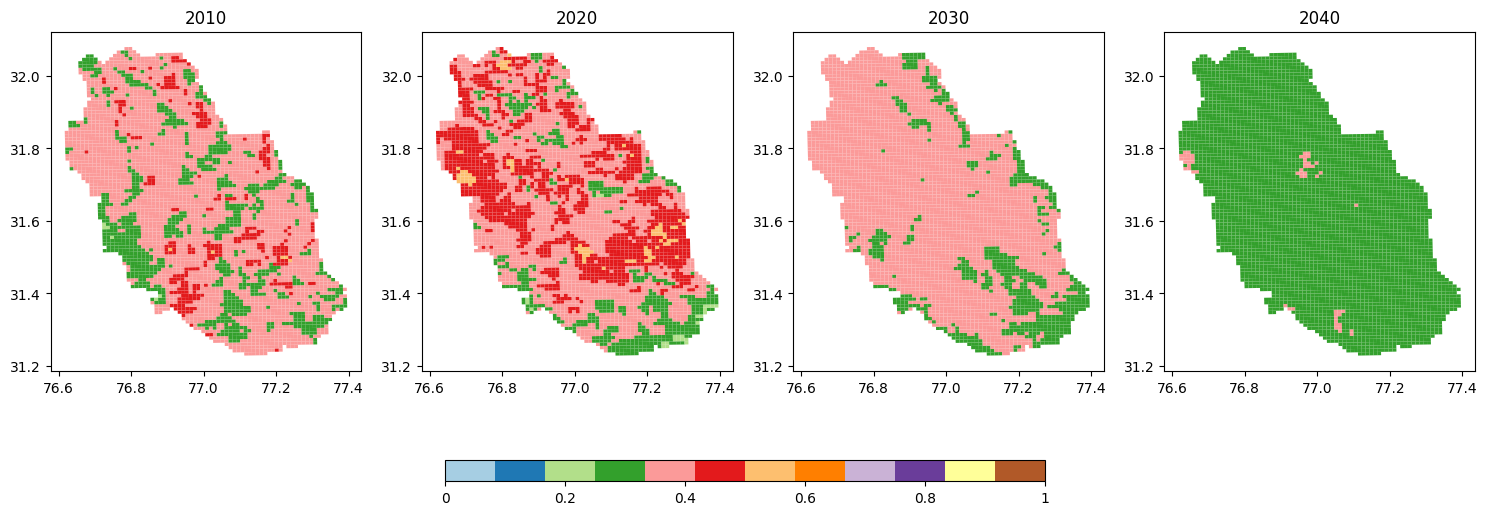

In [76]:
## For evi plot

import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = ''

# Get list of GeoJSON files in the directory
geojson_files = ['mean_evi_2010_06_chunk_0.geojson',
                'mean_evi_2020_06_chunk_0.geojson',
                'month_evi_2030_06_chunk_0.geojson',
                'month_evi_2040_06_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'filtered_grids_mandi.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 4
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows + 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 1  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)

    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]

    # Plot each filtered GeoDataFrame in the corresponding subplot
    filtered_gdf.plot(column='mean_evi', cmap='Paired', ax=axes[i], norm=norm, aspect='equal')
    axes[i].set_title(file_name.split('_')[2])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure even spacing and prevent overlap
plt.tight_layout()

# Add a common colorbar at the bottom with added space
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])  # Adjusted for bottom placement
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels (for example, 25 custom labels)
custom_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('evi_raster_himachal.pdf', format='pdf')
plt.show()

In [55]:
## Save predictions to geojson file

import geopandas as gpd
import numpy as np

def replace_geojson_values(input_file, output_file, new_values):
    # Load the GeoJSON file
    gdf = gpd.read_file(input_file)

    # Ensure the number of new values matches the number of features
    if len(new_values) != len(gdf):
        raise ValueError("The number of new values must match the number of features in the GeoJSON file.")

    # Replace the values in a specified column (e.g., 'value')
    # If 'value' column doesn't exist, it will be created
    gdf['mean_population'] = new_values

    # Save the modified GeoJSON to a new file
    gdf.to_file(output_file, driver='GeoJSON')

    print(f"Modified GeoJSON saved to {output_file}")

# Example usage
if __name__ == "__main__":
    input_file = "filtered_grids_mandi.geojson"

    replace_geojson_values(input_file, 'mean_population_2030_chunk_0.geojson', predictions[1, :, :, 0][0])
    replace_geojson_values(input_file, 'mean_population_2040_chunk_0.geojson', predictions[2, :, :, 0][0])

Modified GeoJSON saved to mean_population_2030_chunk_0.geojson
Modified GeoJSON saved to mean_population_2040_chunk_0.geojson


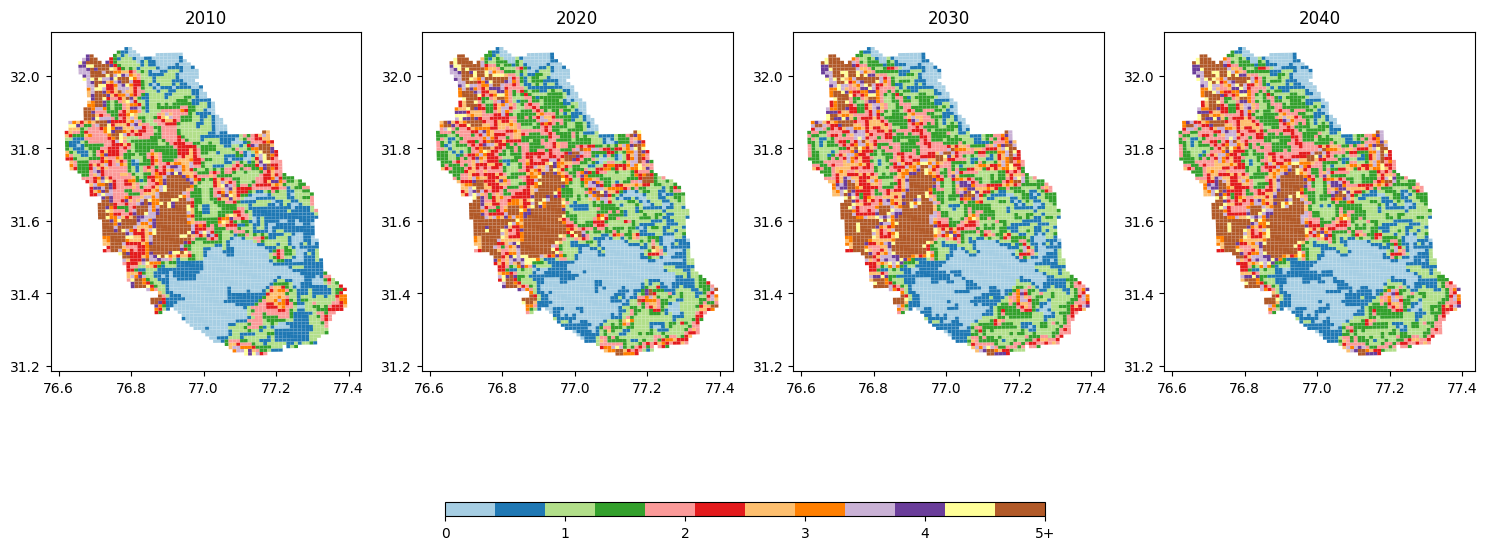

In [56]:
## For pop plot

import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib import colors

# Directory containing the GeoJSON files
directory = ''

# Get list of GeoJSON files in the directory
geojson_files = ['mean_population_2010_chunk_0.geojson',
                'mean_population_2020_chunk_0.geojson',
                'mean_population_2030_chunk_0.geojson',
                 'mean_population_2040_chunk_0.geojson']

# Path to the filtered GeoJSON file
filtered_geojson_path = os.path.join(directory, 'filtered_grids_mandi.geojson')

# Load the filtered GeoJSON file and extract the grid IDs
filtered_gdf = gpd.read_file(filtered_geojson_path)
filtered_grid_ids = filtered_gdf['FID'].tolist()  # Assumes grid_id is a column

# Number of rows and columns for subplots
n_cols = 4
n_rows = (len(geojson_files) + n_cols - 1) // n_cols  # Ensures enough rows for all files

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows + 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create a color normalization object for common color range
vmin, vmax = 0, 5  # Adjust this based on the population range
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Loop through GeoJSON files and plot each
for i, file_name in enumerate(geojson_files):
    file_path = os.path.join(directory, file_name)

    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Filter the GeoDataFrame to include only rows with grid IDs in the filtered_grid_ids
    filtered_gdf = gdf[gdf['FID'].isin(filtered_grid_ids)]

    # Plot each filtered GeoDataFrame in the corresponding subplot
    filtered_gdf.plot(column='mean_population', cmap='Paired', ax=axes[i], norm=norm, aspect='equal')
    axes[i].set_title(file_name.split('_')[2])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure even spacing and prevent overlap
plt.tight_layout()

# Add a common colorbar at the bottom with added space
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])  # Adjusted for bottom placement
sm = plt.cm.ScalarMappable(cmap='Paired', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Create custom labels (for example, 25 custom labels)
custom_labels = ['0', '1', '2', '3', '4', '5+']

# Set the custom ticks and labels on the colorbar
num_labels = len(custom_labels)
cbar.set_ticks([vmin + i * (vmax - vmin) / (num_labels - 1) for i in range(num_labels)])  # Set positions
cbar.set_ticklabels(custom_labels)  # Set the corresponding labels

# Save the plot as a PDF
plt.savefig('pop_raster_himachal_2k.pdf', format='pdf')
plt.show()